### Imports

In [2]:
import os
os.environ['DGLBACKEND'] = 'pytorch'

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

import matplotlib.pyplot as plt
from visualize import *
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from modeling import *
from sklearn.metrics import roc_curve, f1_score
from sklearn.model_selection import ParameterGrid

import networkx as nx
import dgl
import dgl.data
from dgl.nn import GINEConv, SAGEConv, GINConv
from sentence_transformers import SentenceTransformer

import time
import re
from itertools import permutations, combinations_with_replacement
from tqdm import tqdm

from const import *
from dadata import Dadata

## Введение 

### Тема: Построение рекомендательной системы для предсказания исполнителей контрактов на закупки с учетом географического расположения контрагентов

**Цели курсовой работы:**
1. Построение модели для рекомендации исполнителей контрактов на закупки, учитывая географическое расположение контрагентов и их виды деятельности.
2. Проверка качества правильного предсказания модели на тестовой выборке.
3. Построение рекомендательной системы для предсказания исполнителей контрактов на закупки с учетом географического расположения контрагентов.

Будет представлено решение задачи **Link-Prediction**, которая заключается в предсказании связей между объектами. В данном случае объектами являются поставщики и заказчики.

**Задачи работы:**

**1. Сбор данных**
* получить данные о контрактах с ЕИС в сферез закупок
* Получить данные по каждой компании, используя API сервиса DaData

**2. Предобработка и визуализация**
* визуализация - распределение признаков, распределение компаний по территории РФ

**3. Подготовка графа**
* подготовка данных для представления в виде графа
* представление данных в виде графа
* разделение данных на обучающую и тестовую выборки

**4. Выбор модели**
* выбор базовой архтектуры модели
* определение оптимального кол-ва слоев, оптимизатора, предиткора и т.д.
* визузализация характеристик моделей для их сравнения

**5. Обучение модели, оценка качества**
* обучить выбранную модель
* выбрать метрику оценки качества и оценить результаты предсказаний

**6. Создание рекомендательной системы**
* определение удобной для использования функции предсказания исполнителей/поставщиков

**Ожидаемый результат** - **рекомендательная система**, которая с высокой точностью будет предсказывать исполнителей контрактов на закупки с учетом географического расположения контрагентов.

## Сбор данных

### Сбор информации о контрактах

Для поиска данных по контрактам используется [официальный сайт Единой информационной системы в сфере закупок](https://zakupki.gov.ru/epz/main/public/home.html). На этом ресурсе размещаются сведения о закупках в соответствии с федеральными законами [№ 44-ФЗ](https://www.consultant.ru/document/cons_doc_LAW_144624/) и [№ 94-ФЗ](https://www.consultant.ru/document/cons_doc_LAW_54598/). 

Функционал сайта позволяет выгрузить до 5000 элементов. Для решаемых нами задач выгрузим следующие значения контрактов:
* Реестровый номер контракта
* ИНН заказчика
* ИНН исполнителя
* Предмет контракта
* Сумма контракта

In [2]:
# файлы, полученные с ЕИС
os.listdir('ContractsInfoNew')

['ContractSearch(1-500)_27.04.2024.csv',
 'ContractSearch(1001-1500)_27.04.2024.csv',
 'ContractSearch(1501-2000)_27.04.2024.csv',
 'ContractSearch(2001-2500)_27.04.2024.csv',
 'ContractSearch(2501-3000)_27.04.2024.csv',
 'ContractSearch(3001-3500)_27.04.2024.csv',
 'ContractSearch(3501-4000)_27.04.2024.csv',
 'ContractSearch(4001-4500)_27.04.2024.csv',
 'ContractSearch(4501-5000)_27.04.2024.csv',
 'ContractSearch(501-1000)_27.04.2024.csv']

In [3]:
contracts_info = pd.concat([pd.read_csv(f'ContractsInfoNew/{file}', encoding='cp1251', delimiter=';') for file in os.listdir('ContractsInfoNew')], ignore_index=True)  
contracts_info.head(3)

Номер реестровой записи контракта Заказчик: ИНН  \
0             '2550302559324000245'  '5503025593'   
1             '2683202476623000412'  '6832024766'   
2             '2263300261924000083'  '2633002619'   

                                   Предмет контракта Цена контракта  \
0           'Поставка яиц куриных в скорлупе свежих'    '11 340,00'   
1  '  поставка элементов питания к индивидуальном...   '223 299,83'   
2  'Поставка лекарственного препарата для медицин...   '126 893,25'   

  Информация о поставщиках (исполнителях, подрядчиках) по контракту: ИНН  
0                                     '550504994420'                      
1                                       '7721129652'                      
2                                       '4003032047'

Предобработает значения в датафрейме, убрав кавычки `'`

In [4]:
for column in contracts_info.columns:
    contracts_info[column] = contracts_info[column].str.replace("'", '')
contracts_info['Цена контракта'] = contracts_info['Цена контракта'].str.replace(' ', '').str.replace(',', '.')
contracts_info.rename(columns={'Информация о поставщиках (исполнителях, подрядчиках) по контракту: ИНН': 'Исполнитель: ИНН'}, inplace=True)
contracts_info.head(3)

Номер реестровой записи контракта Заказчик: ИНН  \
0               2550302559324000245    5503025593   
1               2683202476623000412    6832024766   
2               2263300261924000083    2633002619   

                                   Предмет контракта Цена контракта  \
0             Поставка яиц куриных в скорлупе свежих       11340.00   
1    поставка элементов питания к индивидуальному...      223299.83   
2  Поставка лекарственного препарата для медицинс...      126893.25   

  Исполнитель: ИНН  
0     550504994420  
1       7721129652  
2       4003032047

In [5]:
contracts_info.shape

(5000, 5)

### Сбор информации о контрагентах

Для получения информации о заказчиках и исполнителях используется ресурс [DaData](https://dadata.ru). Функционал сайта включает в себя довольно гибкое [API](https://dadata.ru/api/find-party/), которое позволит по ИНН найти юр. адрес компании в виде географических координат, а также основной ОКВЭД.

In [9]:
dadata = Dadata(DADATA_TOKEN, DADATA_SECRET)

def get_info_by_tin(TIN: str) -> tuple:
    
    time.sleep(1) # обход ограничения в виде 60 запросов в минуту

    try:
        info = dadata.find_by_id(name='party', query=TIN)[0]['data']

        lat = info['address']['data']['geo_lat']
        lon = info['address']['data']['geo_lon']
        if info['address']['data']['city'] is None:
            location = info['address']['data']['settlement']
        else:
            location = info['address']['data']['city']
        okved = info['data']['okved']

        return lat, lon, location, okved
    except:
        return None, None, None, None

Так как возможны сбои в работе API или интернета, реализуем возможность сохранения промежуточных результатов. Для этого исходный датафрейм разделяется на батчи равного размера *(в данном случае 50 строк)*, каждый батч обрабатывается и после завершения обработки сохраняется в указанную директорию

In [173]:
if not os.path.exists(TEMP_DIR):
    os.mkdir(TEMP_DIR)
    
for i in tqdm(range(0, contracts_info.shape[0]+50, 50)):

    if dadata.get_daily_stats()['remaining']['suggestions'] < 100:     # проверка наличия квоты на использование API
        raise Exception(f'Достигнут суточный лимит использования API. Последний обработанный индекс: {i-50}') # лимит бесплатных запросов: 10000 / день
    
    df = contracts_info.iloc[i-50:i]
    
    df[['Заказчик: широта', 'Заказчик: долгота', 'Заказчик: населенный пункт']] =\
    df['Заказчик: ИНН'].apply(get_info_by_tin).apply(pd.Series) 

    df[['Исполнитель: широта', 'Исполнитель: долгота', 'Исполнитель: населенный пункт']] =\
    df['Исполнитель: ИНН'].apply(get_info_by_tin).apply(pd.Series)

    df.to_csv(f'{TEMP_DIR}/({i-50}-{i}).csv')

100%|██████████| 1/1 [02:41<00:00, 161.91s/it]


После обработки всех батчей собираем их в единый датасет

In [4]:
files = os.listdir(TEMP_DIR)
print(f'Кол-во промежуточных файлов: {len(files)}')
contracts_info = pd.concat([pd.read_csv(f'{TEMP_DIR}/{file}') for file in files])
contracts_info.drop('Unnamed: 0', axis=1, inplace=True)

Кол-во промежуточных файлов: 100


Проверим, есть ли в данных пропуски, и, если они присутствуют, удалим их

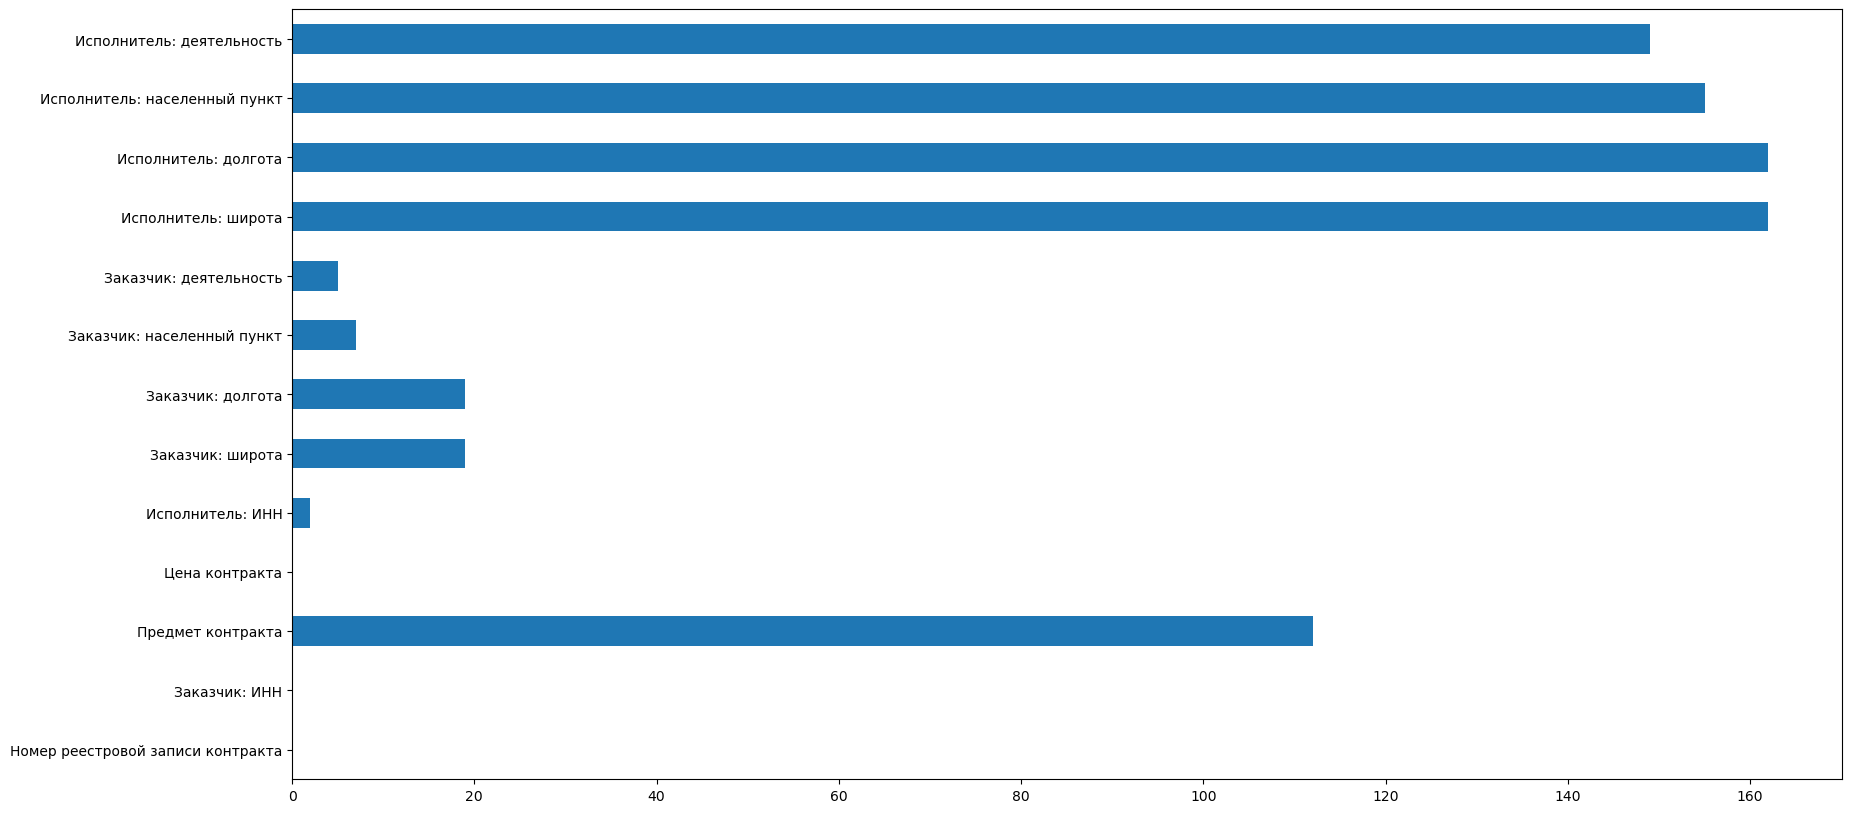

In [7]:
contracts_info.isna().sum().plot.barh(figsize=FIGSIZE)
orig_shape = contracts_info.shape
plt.show()

In [12]:
contracts_info.dropna(inplace=True, ignore_index=True)
print(f'Изначальный размер: {orig_shape}')
print(f'Новый размер: {contracts_info.shape}')

Изначальный размер: (5000, 13)
Новый размер: (4714, 13)


Визуализируем расположение заказчиков и исполнителей на территории России

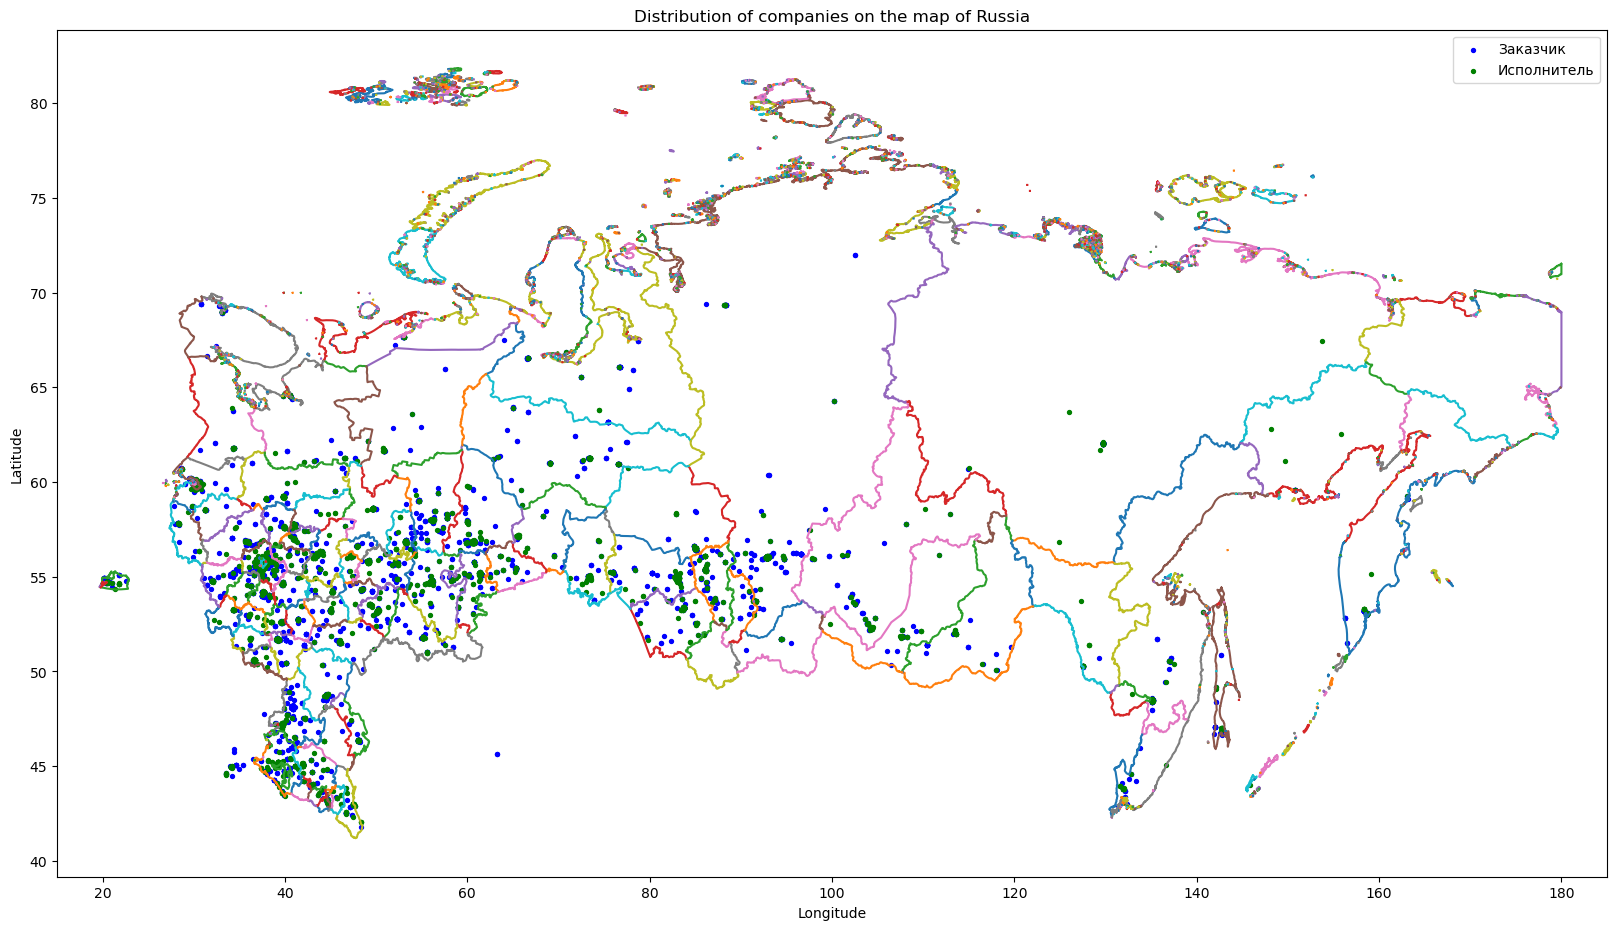

In [13]:
data_for_plotting = {
    'labels': ['Заказчик', 'Исполнитель'],
    'lats': [contracts_info['Заказчик: широта'], contracts_info['Исполнитель: широта']],
    'lons': [contracts_info['Заказчик: долгота'], contracts_info['Исполнитель: долгота']]
}
plot_scatter_on_map(data_for_plotting)

### Добавление информации о видах деятельности

Датафрейм содержит основной код [ОКВЭД](https://ru.wikipedia.org/wiki/%D0%9E%D0%B1%D1%89%D0%B5%D1%80%D0%BE%D1%81%D1%81%D0%B8%D0%B9%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80_%D0%B2%D0%B8%D0%B4%D0%BE%D0%B2_%D1%8D%D0%BA%D0%BE%D0%BD%D0%BE%D0%BC%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B9_%D0%B4%D0%B5%D1%8F%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D0%B8) для каждой компании. Заменим их на текстовое представление. Для этого создадим датафрейм с кодами ОКВЭД и их текстовыми значенями.\
*(okved.csv взят [отсюда](https://classifikators.ru/okved#download))*

In [379]:
okved = pd.read_csv('okved.csv', encoding='cp1251', delimiter=';').drop('A', axis=1)
okved.columns = ['Код', 'Деятельность']
okved = okved.loc[okved['Код'] != ' ']
okved.set_index('Код', inplace=True)
okved.loc['72.6'] = 'Прочая деятельность, связанная с использованием вычислительной техники и информационных технологий'
okved

Деятельность
Код                                                        
01        Растениеводство и животноводство, охота и пред...
01.1                         Выращивание однолетних культур
01.11     Выращивание зерновых (кроме риса), зернобобовы...
01.11.1                        Выращивание зерновых культур
01.11.11                                Выращивание пшеницы
...                                                     ...
98.20     Деятельность недифференцированная частных дома...
99        Деятельность экстерриториальных организаций и ...
99.0      Деятельность экстерриториальных организаций и ...
99.00     Деятельность экстерриториальных организаций и ...
72.6      Прочая деятельность, связанная с использование...

[2888 rows x 1 columns]

In [380]:
okved.to_csv('okved.csv')

In [28]:
contracts_info['Исполнитель: деятельность'] = okved.loc[contracts_info['Исполнитель: деятельность']].values.flatten()
contracts_info['Заказчик: деятельность'] = okved.loc[contracts_info['Заказчик: деятельность']].values.flatten()
contracts_info.to_csv('contracts_info1.csv')

## Предобработка данных

### Предобработка данных для построения графа

Загрузка набора данных, полученного на предыдущих этапах

In [140]:
# Загрузка обработанного датафрейма из csv
df = pd.read_csv('contracts_info1.csv', index_col='Unnamed: 0')
df.rename(columns={'Информация о поставщиках (исполнителях, подрядчиках) по контракту: ИНН': 'Исполнитель: ИНН'}, inplace=True)
df['Исполнитель: ИНН'] = df['Исполнитель: ИНН'].astype(np.int64)
df['Заказчик: ИНН'] = df['Заказчик: ИНН'].astype(np.int64)
df['Цена контракта'] = df['Цена контракта'].str.replace(' ', '').str.replace(',', '.')
df['Цена контракта'] = df['Цена контракта'].astype(float)
df.head(3)

Номер реестровой записи контракта  Заказчик: ИНН  \
0                2550302559324000245     5503025593   
1                2683202476623000412     6832024766   
2                2263300261924000083     2633002619   

                                   Предмет контракта  Цена контракта  \
0             Поставка яиц куриных в скорлупе свежих        11340.00   
1    поставка элементов питания к индивидуальному...       223299.83   
2  Поставка лекарственного препарата для медицинс...       126893.25   

   Исполнитель: ИНН  Заказчик: широта  Заказчик: долгота  \
0      550504994420         55.040379          73.444200   
1        7721129652         52.761967          41.421830   
2        4003032047         45.039423          41.937529   

  Заказчик: населенный пункт               Заказчик: деятельность  \
0                       Омск  Деятельность больничных организаций   
1                     Тамбов  Деятельность больничных организаций   
2                 Ставрополь  Деятельность больничных организаций   

   Исполнитель: широта  Исполнитель: долгота Исполнитель: населенный пункт  \
0            54.984857             73.367452                          Омск   
1            55.731414             37.765595                        Москва   
2            55.733283             37.697164                        Москва   

                         Исполнитель: деятельность  
0                          Торговля оптовая яйцами  
1  Торговля оптовая электрической бытовой техникой  
2     Торговля оптовая фармацевтической продукцией

In [359]:
df.shape

(4714, 13)

Так как в нашем датасете присутствуют как юридические лица, так и индивидуальные предприниматели, добавим столбец `legal`, определяющий, к какому типу принадлежит предприятие.
Одной из причин, по который добавляется этот признак, является местоположение ИП - API для ИП в качестве местоположения возвращает координаты ИФНС района, где живет предприниматель. Обилие узлов с одинаковым местоположение может являться проблемой при обучении модели

In [141]:
def get_legal(row):
    len_ = len(str(row['ИНН']))
    if len_ < 11:
        row['legal'] = 'ЮЛ'
    else:
        row['legal'] = 'ИП'
    return row

Создадим датафрейм из уникальных ИНН, в дальнейшем будем работать с ним

In [155]:
df_features = pd.DataFrame(np.unique(np.hstack([df['Заказчик: ИНН'].values, df['Исполнитель: ИНН'].values])), columns=['ИНН'])
df_features = df_features.apply(get_legal, axis=1)
df_features.head(3)

ИНН legal
0  103008080    ЮЛ
1  104000904    ЮЛ
2  105017386    ЮЛ

In [156]:
df_features.to_csv('tin_legal.csv')

### Добавление эмбеддингов

Используем в нашей рекомендательной системе не только данные о местоположении контрагента, но и информацию об их видах деятельности и сути контракта

Создадим датафрейм текстовый признаков, содержащий виды деятельности компаний и предметы контрактов

In [363]:
df_features_str = pd.DataFrame(np.unique(np.hstack([df['Заказчик: деятельность'].values, df['Исполнитель: деятельность'].values, df['Предмет контракта'].values])), columns=['str'])
df_features_str['str'] = df_features_str['str'].map(preproc_strigs)
df_features_str

str
0     поставка элементов питания к индивидуальному б...
1     Изготовление и поставка сценических костюмов Ф...
2      Поставка повязок с лекарственными средствами ЛОТ
3     Электронный аукцион поставку расходных материа...
4     На поставку средства дезинфицирующего Никасупе...
...                                                 ...
4473  Перчатки смотровыепроцедурные нитриловые неопу...
4474                         Бумага для офисной техники
4475        зз Швейные текстильные изделия кроме одежды
4476  аэфст Поставка учебных лабораторий по нейротех...
4477  аэфст Поставка набора по закреплению изучаемых...

[4478 rows x 1 columns]

Для создания эмбеддингов используем фреймворк [SentenceTransformer](https://www.sbert.net/) и модель [paraphrase-multilingual-MiniLM-L12-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2)

In [364]:
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

c:\Users\User\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [41]:
sentences = df_features_str['str'].values
sentence_embeddings = model.encode(sentences)

In [42]:
df_features_str['embeddings'] = sentence_embeddings.tolist()
df_features_str.set_index('str', inplace=True)
df_features_str = df_features_str[~df_features_str.index.duplicated(keep='first')]
df_features_str

embeddings
str                                                                                                  
поставка элементов питания к индивидуальному бе...  [-0.2575603127479553, 0.20988829433918, 0.0386...
Изготовление и поставка сценических костюмов Фа...  [0.01244316529482603, 0.2799169421195984, 0.13...
Поставка повязок с лекарственными средствами ЛОТ    [-0.1156575083732605, 0.04869977757334709, -0....
Электронный аукцион поставку расходных материал...  [-0.07269664853811264, 0.3977573812007904, 0.0...
На поставку средства дезинфицирующего Никасупер...  [-0.05825350061058998, 0.4315146803855896, -0....
...                                                                                               ...
Рыба для учреждений Первомайского района г Ижевска  [0.12616239488124847, 0.19819054007530212, 0.2...
Перчатки смотровыепроцедурные нитриловые неопуд...  [-0.1807262897491455, 0.29004237055778503, -0....
зз Швейные текстильные изделия кроме одежды         [-0.07644530385732651, 0.19987493753433228, 0....
аэфст Поставка учебных лабораторий по нейротехн...  [0.07514987140893936, 0.05332570895552635, 0.0...
аэфст Поставка набора по закреплению изучаемых ...  [0.08123812079429626, -0.006463943514972925, 0...

[4354 rows x 1 columns]

Сохраним полученный датафрейм

In [43]:
df_features_str.to_csv('features_str.csv')

Заменим значения столбца `Предмет контракта` со строк на их эмбеддинги

In [46]:
df['Предмет контракта'] = df['Предмет контракта'].map(preproc_strigs)
df['Предмет контракта'] = df_features_str.loc[df['Предмет контракта']]['embeddings'].values

In [49]:
# Функция для получения списка контрактов для каждого ИНН
def get_contract(TIN, df):
    df_contract = df[df['Заказчик: ИНН'] == TIN]
    df_contract = pd.concat([df_contract, df[df['Исполнитель: ИНН'] == TIN]])
    return df_contract

### Создание датафрейма для построения графа

Полученные данные были представлены относительно контрактов, поэтому для построения графа необходимо было преобразовать данные в относительно исполнителей контрактов. Для этого необходимо сгруппировать данные по исполнителям контрактов и заказчикам, а также объединить данные по исполнителям контрактов и заказчикам.

In [53]:
%%time
def get_features(df_features, df):
    for TIN in df_features['ИНН']:

        # Применение функции для получения списка контрактов для каждого ИНН
        df_contract = get_contract(TIN, df)

        # Создание списка ребер для каждого ИНН. Ребра - это ИННы контрагентов(поставщик -> покупатель)
        list_edges_1 = df_contract[df_contract['Заказчик: ИНН'] != TIN]['Заказчик: ИНН'].unique().tolist()
        list_edges_2 = df_contract[df_contract['Заказчик: ИНН'] != TIN]['Предмет контракта'].tolist()
        # Создание вспомогательного класса для хранения списка ребер
        class edges(object):
            def __init__(self, li_obj):
                self.obj = li_obj

        # Добавление списка ребер в датафрейм фичей
        df_features.loc[df_features['ИНН'] == TIN, 'edges1'] = edges(list_edges_1)
        df_features.loc[df_features['ИНН'] == TIN, 'edges2'] = edges(list_edges_2)
        
        # Добавление фичей по цене
        df_features.loc[df_features['ИНН'] == TIN, 'mean'] = df_contract['Цена контракта'].mean()
        df_features.loc[df_features['ИНН'] == TIN, 'max'] = df_contract['Цена контракта'].max()
        df_features.loc[df_features['ИНН'] == TIN, 'min'] = df_contract['Цена контракта'].min()
        df_features.loc[df_features['ИНН'] == TIN, 'median'] = df_contract['Цена контракта'].median()
        
        # Добавление фичей по количеству контрагентов
        df_features.loc[df_features['ИНН'] == TIN, 'count_supplier'] = len(df_contract['Исполнитель: ИНН'].unique())
        df_features.loc[df_features['ИНН'] == TIN, 'count_purchaser'] = len(df_contract['Заказчик: ИНН'].unique())
        if TIN in df_contract['Исполнитель: ИНН'].unique():
            df_features.loc[df_features['ИНН'] == TIN, 'count_supplier'] -= 1
        if TIN in df_contract['Заказчик: ИНН'].unique():
            df_features.loc[df_features['ИНН'] == TIN, 'count_purchaser'] -= 1


# Применение функции для получения фичей для каждого ИНН
get_features(df_features, df)

CPU times: total: 31.2 s
Wall time: 31.4 s


In [54]:
# Замена объектов на их значения, а также заполнение пропусков нулями
df_features['edges1'] = df_features['edges1'].apply(lambda x: x.obj)
df_features['edges2'] = df_features['edges2'].apply(lambda x: x.obj)
df_features = df_features.fillna(0)

In [55]:
df_features

ИНН legal        edges1  \
0        103008080    ЮЛ            []   
1        104000904    ЮЛ            []   
2        105017386    ЮЛ            []   
3        105022178    ЮЛ            []   
4        105025965    ЮЛ            []   
...            ...   ...           ...   
5242  910203540394    ИП  [9102161148]   
5243  910213339871    ИП  [8601030928]   
5244  910216687901    ИП  [7811001382]   
5245  910232332582    ИП  [3017002428]   
5246  910903280575    ИП  [9109006737]   

                                                 edges2         mean  \
0                                                    []   178342.930   
1                                                    []   391018.925   
2                                                    []  5072226.200   
3                                                    []   580000.000   
4                                                    []  2322000.000   
...                                                 ...          ...   
5242  [[0.007960445247590542, 0.14081992208957672, -...   665309.740   
5243  [[-0.254529744386673, 0.055903296917676926, 0....  1086180.000   
5244  [[-0.031563207507133484, 0.04150817543268204, ...   617523.700   
5245  [[-0.1317748874425888, 0.1917593628168106, 0.0...    45128.820   
5246  [[-0.03402391076087952, 0.021747494116425514, ...    99180.000   

             max         min       median  count_supplier  count_purchaser  
0      216884.50   139801.36   178342.930             2.0              0.0  
1      587038.48   194999.37   391018.925             2.0              0.0  
2     9831744.00   312708.40  5072226.200             2.0              0.0  
3      580000.00   580000.00   580000.000             1.0              0.0  
4     2322000.00  2322000.00  2322000.000             1.0              0.0  
...          ...         ...          ...             ...              ...  
5242   665309.74   665309.74   665309.740             0.0              1.0  
5243  1086180.00  1086180.00  1086180.000             0.0              1.0  
5244   617523.70   617523.70   617523.700             0.0              1.0  
5245    45128.82    45128.82    45128.820             0.0              1.0  
5246    99180.00    99180.00    99180.000             0.0              1.0  

[5247 rows x 10 columns]

Добавим в датафрейм признаков информацию о долготе и широте

In [56]:
df1 = df[['Заказчик: ИНН', 'Заказчик: широта', 'Заказчик: долгота']]
df2 = df[['Исполнитель: ИНН', 'Исполнитель: широта', 'Исполнитель: долгота']]
rename_dict_1 = dict(zip(df1.columns, ['ИНН', 'lat', 'lon']))
rename_dict_2 = dict(zip(df2.columns, ['ИНН', 'lat', 'lon']))
df1.rename(columns=rename_dict_1, inplace=True)
df2.rename(columns=rename_dict_2, inplace=True)

In [57]:
tin_w_coord = pd.concat([df1, df2]).drop_duplicates()
tin_w_coord['ИНН'] = tin_w_coord['ИНН'].astype(np.int64)
tin_w_coord.set_index('ИНН', inplace=True)
tin_w_coord.head(3)

lat        lon
ИНН                             
5503025593  55.040379  73.444200
6832024766  52.761967  41.421830
2633002619  45.039423  41.937529

In [58]:
df_features['lat'] = tin_w_coord.loc[df_features['ИНН']]['lat'].values
df_features['lon'] = tin_w_coord.loc[df_features['ИНН']]['lon'].values
df_features

ИНН legal        edges1  \
0        103008080    ЮЛ            []   
1        104000904    ЮЛ            []   
2        105017386    ЮЛ            []   
3        105022178    ЮЛ            []   
4        105025965    ЮЛ            []   
...            ...   ...           ...   
5242  910203540394    ИП  [9102161148]   
5243  910213339871    ИП  [8601030928]   
5244  910216687901    ИП  [7811001382]   
5245  910232332582    ИП  [3017002428]   
5246  910903280575    ИП  [9109006737]   

                                                 edges2         mean  \
0                                                    []   178342.930   
1                                                    []   391018.925   
2                                                    []  5072226.200   
3                                                    []   580000.000   
4                                                    []  2322000.000   
...                                                 ...          ...   
5242  [[0.007960445247590542, 0.14081992208957672, -...   665309.740   
5243  [[-0.254529744386673, 0.055903296917676926, 0....  1086180.000   
5244  [[-0.031563207507133484, 0.04150817543268204, ...   617523.700   
5245  [[-0.1317748874425888, 0.1917593628168106, 0.0...    45128.820   
5246  [[-0.03402391076087952, 0.021747494116425514, ...    99180.000   

             max         min       median  count_supplier  count_purchaser  \
0      216884.50   139801.36   178342.930             2.0              0.0   
1      587038.48   194999.37   391018.925             2.0              0.0   
2     9831744.00   312708.40  5072226.200             2.0              0.0   
3      580000.00   580000.00   580000.000             1.0              0.0   
4     2322000.00  2322000.00  2322000.000             1.0              0.0   
...          ...         ...          ...             ...              ...   
5242   665309.74   665309.74   665309.740             0.0              1.0   
5243  1086180.00  1086180.00  1086180.000             0.0              1.0   
5244   617523.70   617523.70   617523.700             0.0              1.0   
5245    45128.82    45128.82    45128.820             0.0              1.0   
5246    99180.00    99180.00    99180.000             0.0              1.0   

            lat        lon  
0     44.899313  40.489795  
1     44.507421  40.177448  
2     44.593895  40.135497  
3     44.610402  40.107217  
4     44.601061  40.106771  
...         ...        ...  
5242  44.948295  34.100115  
5243  44.948295  34.100115  
5244  44.948295  34.100115  
5245  44.948295  34.100115  
5246  44.920884  34.231888  

[5247 rows x 12 columns]

In [61]:
df1 = df[['Заказчик: ИНН', 'Заказчик: деятельность']]
df2 = df[['Исполнитель: ИНН', 'Исполнитель: деятельность']]
rename_dict_1 = dict(zip(df1.columns, ['ИНН', 'activity']))
rename_dict_2 = dict(zip(df2.columns, ['ИНН', 'activity']))
df1.rename(columns=rename_dict_1, inplace=True)
df2.rename(columns=rename_dict_2, inplace=True)

In [73]:
tin_w_activity = pd.concat([df1, df2]).drop_duplicates()
tin_w_activity['activity'] = tin_w_activity['activity'].map(preproc_strigs)
tin_w_activity['ИНН'] = tin_w_activity['ИНН'].astype(np.int64)
tin_w_activity.set_index('ИНН', inplace=True)
tin_w_activity = tin_w_activity[~tin_w_activity.index.duplicated(keep='first')]
tin_w_activity['activity'] = df_features_str.loc[tin_w_activity['activity']]['embeddings'].values
tin_w_activity.head()

activity
ИНН                                                          
5503025593  [-0.028958480805158615, 0.028822055086493492, ...
6832024766  [-0.028958480805158615, 0.028822055086493492, ...
2633002619  [-0.028958480805158615, 0.028822055086493492, ...
3525279171  [0.2871737480163574, 0.040776193141937256, -0....
7453135827  [-0.07675240933895111, -0.031104184687137604, ...

In [74]:
df_features['activity'] = tin_w_activity.loc[df_features['ИНН']]['activity'].values
df_features

ИНН legal        edges1  \
0        103008080    ЮЛ            []   
1        104000904    ЮЛ            []   
2        105017386    ЮЛ            []   
3        105022178    ЮЛ            []   
4        105025965    ЮЛ            []   
...            ...   ...           ...   
5242  910203540394    ИП  [9102161148]   
5243  910213339871    ИП  [8601030928]   
5244  910216687901    ИП  [7811001382]   
5245  910232332582    ИП  [3017002428]   
5246  910903280575    ИП  [9109006737]   

                                                 edges2         mean  \
0                                                    []   178342.930   
1                                                    []   391018.925   
2                                                    []  5072226.200   
3                                                    []   580000.000   
4                                                    []  2322000.000   
...                                                 ...          ...   
5242  [[0.007960445247590542, 0.14081992208957672, -...   665309.740   
5243  [[-0.254529744386673, 0.055903296917676926, 0....  1086180.000   
5244  [[-0.031563207507133484, 0.04150817543268204, ...   617523.700   
5245  [[-0.1317748874425888, 0.1917593628168106, 0.0...    45128.820   
5246  [[-0.03402391076087952, 0.021747494116425514, ...    99180.000   

             max         min       median  count_supplier  count_purchaser  \
0      216884.50   139801.36   178342.930             2.0              0.0   
1      587038.48   194999.37   391018.925             2.0              0.0   
2     9831744.00   312708.40  5072226.200             2.0              0.0   
3      580000.00   580000.00   580000.000             1.0              0.0   
4     2322000.00  2322000.00  2322000.000             1.0              0.0   
...          ...         ...          ...             ...              ...   
5242   665309.74   665309.74   665309.740             0.0              1.0   
5243  1086180.00  1086180.00  1086180.000             0.0              1.0   
5244   617523.70   617523.70   617523.700             0.0              1.0   
5245    45128.82    45128.82    45128.820             0.0              1.0   
5246    99180.00    99180.00    99180.000             0.0              1.0   

            lat        lon                                           activity  
0     44.899313  40.489795  [-0.018847163766622543, 0.15152429044246674, 0...  
1     44.507421  40.177448  [-0.018847163766622543, 0.15152429044246674, 0...  
2     44.593895  40.135497  [-0.028958480805158615, 0.028822055086493492, ...  
3     44.610402  40.107217  [0.15007685124874115, -0.09885182231664658, 0....  
4     44.601061  40.106771  [-0.028958480805158615, 0.028822055086493492, ...  
...         ...        ...                                                ...  
5242  44.948295  34.100115  [0.013471627607941628, -0.21256151795387268, -...  
5243  44.948295  34.100115  [0.05334094539284706, -0.045171625912189484, 0...  
5244  44.948295  34.100115  [-0.043382469564676285, -0.12293514609336853, ...  
5245  44.948295  34.100115  [-0.06595620512962341, -0.09542043507099152, -...  
5246  44.920884  34.231888  [-0.30092912912368774, -0.07779673486948013, -...  

[5247 rows x 13 columns]

In [75]:
df_features.to_csv('features.csv')

In [79]:
df_features_numeric = df_features.copy().select_dtypes('number').drop('ИНН', axis=1)
df_features_numeric

mean         max         min       median  count_supplier  \
0      178342.930   216884.50   139801.36   178342.930             2.0   
1      391018.925   587038.48   194999.37   391018.925             2.0   
2     5072226.200  9831744.00   312708.40  5072226.200             2.0   
3      580000.000   580000.00   580000.00   580000.000             1.0   
4     2322000.000  2322000.00  2322000.00  2322000.000             1.0   
...           ...         ...         ...          ...             ...   
5242   665309.740   665309.74   665309.74   665309.740             0.0   
5243  1086180.000  1086180.00  1086180.00  1086180.000             0.0   
5244   617523.700   617523.70   617523.70   617523.700             0.0   
5245    45128.820    45128.82    45128.82    45128.820             0.0   
5246    99180.000    99180.00    99180.00    99180.000             0.0   

      count_purchaser        lat        lon  
0                 0.0  44.899313  40.489795  
1                 0.0  44.507421  40.177448  
2                 0.0  44.593895  40.135497  
3                 0.0  44.610402  40.107217  
4                 0.0  44.601061  40.106771  
...               ...        ...        ...  
5242              1.0  44.948295  34.100115  
5243              1.0  44.948295  34.100115  
5244              1.0  44.948295  34.100115  
5245              1.0  44.948295  34.100115  
5246              1.0  44.920884  34.231888  

[5247 rows x 8 columns]

### Стандартизация признаков

Стандартизируем численные признаки

In [82]:
mean = df_features_numeric.mean().values
sigma = df_features_numeric.std().values

df_features_numeric = (df_features_numeric - mean) / sigma
df_features_numeric.head()

mean       max       min    median  count_supplier  count_purchaser  \
0 -0.070855 -0.056770 -0.066202 -0.071949        0.810794        -0.582049   
1 -0.066354 -0.052351 -0.064790 -0.066570        0.810794        -0.582049   
2  0.032711  0.058017 -0.061781  0.051820        0.810794        -0.582049   
3 -0.062355 -0.052435 -0.054946 -0.061791        0.161887        -0.582049   
4 -0.025490 -0.031638 -0.010404 -0.017735        0.161887        -0.582049   

        lat       lon  
0 -2.127688 -0.596740  
1 -2.212910 -0.607668  
2 -2.194105 -0.609136  
3 -2.190515 -0.610126  
4 -2.192546 -0.610141

In [83]:
df_features_numeric.describe().loc['mean':'std'].apply(lambda x: round(x, 5))

mean  max  min  median  count_supplier  count_purchaser  lat  lon
mean  -0.0  0.0 -0.0    -0.0             0.0              0.0  0.0  0.0
std    1.0  1.0  1.0     1.0             1.0              1.0  1.0  1.0

In [84]:
# Сохранение mean и sigma в файлы
np.save('mean.npy', mean)
np.save('sigma.npy', sigma)

In [85]:
# Преобразование датафрейма фичей в numpy массив
numeric_features = np.array(df_features_numeric).astype(np.float32)
numeric_features

array([[-0.07085451, -0.0567703 , -0.06620185, ..., -0.5820495 ,
        -2.1276875 , -0.59673965],
       [-0.0663538 , -0.05235122, -0.06479046, ..., -0.5820495 ,
        -2.2129097 , -0.6076683 ],
       [ 0.03271147,  0.05801659, -0.06178068, ..., -0.5820495 ,
        -2.1941047 , -0.6091361 ],
       ...,
       [-0.06156043, -0.05198727, -0.05398665, ...,  0.19347455,
        -2.1170356 , -0.8203061 ],
       [-0.07367364, -0.0588208 , -0.06862259, ...,  0.19347455,
        -2.1170356 , -0.8203061 ],
       [-0.07252979, -0.05817551, -0.06724052, ...,  0.19347455,
        -2.1229966 , -0.8156956 ]], dtype=float32)

In [86]:
numeric_features.shape

(5247, 8)

## Построение основного графа

In [88]:
G = nx.DiGraph()

G.add_nodes_from(df_features['ИНН'])

for i in tqdm(range(len(df_features))):
    for k, j in enumerate(df_features['edges1'][i]):
        G.add_edge(df_features['ИНН'][i], j, weight=df_features['edges2'][i][k])

for i in range(len(df_features)):
    G.nodes[df_features['ИНН'][i]]['feat'] = numeric_features[i]
    G.nodes[df_features['ИНН'][i]]['activity'] = df_features['activity'][i]

g = dgl.from_networkx(G, node_attrs=['feat', 'activity'], edge_attrs=['weight'])
g

100%|██████████| 5247/5247 [00:00<00:00, 50544.34it/s]


Graph(num_nodes=5247, num_edges=3938,
      ndata_schemes={'feat': Scheme(shape=(8,), dtype=torch.float32), 'activity': Scheme(shape=(384,), dtype=torch.float32)}
      edata_schemes={'weight': Scheme(shape=(384,), dtype=torch.float32)})

In [89]:
dgl.save_graphs('graph2.bin', [g])

## Разделение графа

In [198]:
# Загрузка графа
g = dgl.load_graphs('graph2.bin')[0][0]
g

Graph(num_nodes=5247, num_edges=3938,
      ndata_schemes={'feat': Scheme(shape=(8,), dtype=torch.float32), 'activity': Scheme(shape=(384,), dtype=torch.float32)}
      edata_schemes={'weight': Scheme(shape=(384,), dtype=torch.float32)})

Диаметр компоненты графа — это максимальное расстояние между любыми двумя вершинами внутри этой компоненты. В неориентированном графе компонента связности — это подграф, в котором существует путь между любыми двумя вершинами.

In [199]:
# Разделение графа на компоненты
G = g.to_networkx().to_undirected()
components = list(nx.connected_components(G))

# Подсчет диаметра каждой компоненты
diam = []
for i in range(len(components)):
    diam.append(nx.diameter(G.subgraph(components[i])))
print(f'Макс. диаметр: {max(diam)}\nСредний диаметр: {np.mean(diam)}\nМин. диаметр: {min(diam)}')

Макс. диаметр: 24
Средний диаметр: 1.4286689419795222
Мин. диаметр: 1


Так как средний диаметр графа близок к 2, то скорее всего достаточно 2-3 скрытых слоев.

### Создание графов для обучения

Разделим граф на обучающие и тестовые подграфы для положительных и отрицательных примеров.

**Положительные примеры** (Positive)

Положительные примеры представляют собой реальные существующие связи (ребра) в графе. Эти примеры используются для обучения модели на том, как выглядят существующие связи в графе, чтобы модель могла предсказать, какие новые связи могут появиться.

**Отрицательные примеры** (Negative)

Отрицательные примеры представляют собой пары узлов, между которыми нет связи в графе. Эти примеры используются для обучения модели на том, как выглядят отсутствующие связи, чтобы модель могла избегать предсказания ложных связей.

Размер обучающей выборки - 80% от всего размера графа.

In [205]:
train_g, test_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g = get_train_test_graphs(g)

Сохранение

In [209]:
dgl.save_graphs('graphs.bin', [train_g, test_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g])

## Определение оптимальной модели

Загрузка графов для обучения и тестирования

In [211]:
train_g, test_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g = dgl.load_graphs('graphs.bin')[0]

### Построение модели

Рассмотрим 3 типа слоев свертки из представленных во фреймворке [DGL](https://docs.dgl.ai/en/0.7.x/index.html):
* [SAGEConv](https://docs.dgl.ai/en/0.8.x/generated/dgl.nn.pytorch.conv.SAGEConv.html)
* [GINConv](https://docs.dgl.ai/en/0.8.x/generated/dgl.nn.pytorch.conv.GINConv.html)
* [GINEConv](https://docs.dgl.ai/en/0.8.x/generated/dgl.nn.pytorch.conv.GINEConv.html)

Ниже представлена реализация модели

In [13]:
%%writefile MODEL.py
from torch import nn
import torch
from dgl.nn import GINEConv, SAGEConv, GINConv
import torch.nn.functional as F
class MODEL(nn.Module):
    def __init__(self, 
                 geo_layer,
                 in_feats_geo, 
                 h_feats_geo, 
                 in_feats_act, 
                 h_feats_act,
                 num_geo_layers=2,
                 num_act_layers=2,
                 activation=F.leaky_relu,
                 dropout_geo=0.1,
                 dropout_act=0.1):
        super(MODEL, self).__init__()
        
        self.activation = activation

        # action features part
        self.act_layers = nn.ModuleList()
        for _ in range(num_act_layers):
            self.act_layers.append(GINEConv(nn.Linear(in_feats_act, h_feats_act), learn_eps=False))

        self.fc = nn.Linear(h_feats_act, in_feats_act)
        self.drop_act = nn.Dropout(p=dropout_act)
        
        # geo and price features part
        self.geo_layers = nn.ModuleList()
        if geo_layer == GINConv:
            self.geo_layers.append(GINConv(nn.Linear(in_feats_geo, h_feats_geo)))
            for _ in range(num_geo_layers - 1):
                self.geo_layers.append(GINConv(nn.Linear(h_feats_geo, h_feats_geo)))
        elif geo_layer == SAGEConv:
            self.geo_layers.append(SAGEConv(in_feats_geo, h_feats_geo, aggregator_type='lstm'))
            for _ in range(num_geo_layers - 1):
                self.geo_layers.append(SAGEConv(h_feats_geo, h_feats_geo, aggregator_type='lstm'))
        
        self.drop_geo = nn.Dropout(p=dropout_geo)
    
    def forward(self, g, n_feat_geo, nfeat_act, efeat_act, features='both'):
        assert features in ['both', 'geo', 'act', 'sep'], \
            'features must be either "both", "geo", "sep" or "act"'
        
        h2 = n_feat_geo
        for layer in self.geo_layers:
            h2 = layer(g, h2)
            h2 = self.activation(h2)
            h2 = self.drop_geo(h2)
        
        h1 = self.act_layers[0](g, nfeat_act, efeat_act)
        h1 = self.fc(h1)
        for layer in self.act_layers[1:-1]:
            h1 = layer(g, h1, efeat_act)
            h1 = self.activation(h1)
            h1 = self.fc(h1)
            h1 = self.drop_act(h1)
        h1 = self.act_layers[-1](g, h1, efeat_act)
        
        return {
            'both': torch.cat([h1, h2], axis=1),
            'geo': h2,
            'act': h1,
            'sep': (h1, h2),
        }[features]

Overwriting MODEL.py


In [81]:
from MODEL import MODEL

У модели есть три типа вывода, настраивающиеся с помощью аргумента `features`:
* `features='geo'` - модель использует только признаки узлов, содержащие координаты компании и данные о цене контрактов и возвращает только их превращения. 
* `features='act'` - модель использует только данные о видах деятельности заказчика и исполнителя (признаки узлов и ребер), а также информацию о предмете контракта.
* `features='both'` - модель использует оба вида признаков, возвращает объединенный горизонтально тензор.
* `features='sep'` - модель использует оба вида признаков, возвращает результат обработки раздельно, в виде кортежа.


Модель использует сверточные слои `GINEConv` для обработки признаков-эмбеддингов и слои `GINConv`, `SAGEConv` для обработки признаков с координатами и ценой. Выбор между `GINConv` и `SAGEConv` настраивается аргументом `geo_layer` при инициализации модели.

В качестве функции потерь используется бинарная кросс-энтропия:
$$\mathcal{L} = -\sum_{u\sim v\in \mathcal{D}}\left( y_{u\sim v}\log(\hat{y}_{u\sim v}) + (1-y_{u\sim v})\log(1-\hat{y}_{u\sim v})) \right)$$

Для оценки качества используется значение метрики $\text{ROC AUC}$ на тестовом множестве:
$$\text{ROC AUC} = \int_{0}^{1} \text{TPR}(FPR^{-1}(t)) \, dt$$


### Выбор сверточного слоя

Первым этапом в выборе модели будет выбор между `GINConv` и `SAGEConv` в качестве слоя для обработки признаков с координатами и ценой.

In [213]:
models = [MODEL(
    geo_layer=layer, 
    in_feats_geo=train_g.ndata['feat'].shape[1], 
    h_feats_geo=16, 
    in_feats_act=train_g.ndata['activity'].shape[1], 
    h_feats_act=16
    ) for layer in [SAGEConv, GINConv]
    ]

При нахождении оптимального слоя свертки отключим использование признаков-эмбеддингов

In [214]:
def train(
        model: torch.nn.Module, 
        forward_args: list,
        epoch: int, 
        train_pos_g: dgl.DGLGraph, 
        train_neg_g: dgl.DGLGraph, 
        test_pos_g: dgl.DGLGraph, 
        test_neg_g: dgl.DGLGraph, 
        optimizer: torch.optim, 
        pred, 
        save_logs: bool = True, 
        print_results: bool = False, 
        verbose=20, # save logs every 'verbose' epochs
        save_model: bool = False # path to save model
        ):
    
    losses, aucs = [], []

    for e in tqdm(range(epoch)):
        # forward
        h = model(*forward_args)        
        pos_score = pred(train_pos_g, h)
        neg_score = pred(train_neg_g, h)
        loss = compute_loss(pos_score, neg_score)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % verbose == 0:
            with torch.no_grad():
                pos_score = pred(test_pos_g, h)
                neg_score = pred(test_neg_g, h)
                roc_auc = compute_auc(pos_score, neg_score)
                if save_logs:
                    losses.append(loss.item())
                    aucs.append(roc_auc)
                if print_results:
                    print('In epoch {}, loss: {}, test auc: {}'.format(e, loss.item(), roc_auc))
        
    if save_model:
        torch.save(model, f'{save_model}.pth')
        print(f'Model saved at {save_model}.pth')

    if save_logs:
        return model, losses, aucs
    
    return model

In [215]:
epoch = 500
losses_, aucs_ = [], []
forward_args = [train_g, train_g.ndata['feat'], train_g.ndata['activity'], train_g.edata['weight'], 'geo']
for model in models:
    optimizer = torch.optim.Adam(model.parameters())
    pred = DotPredictor()
    _, losses, aucs = train(model,
                            forward_args,   
                            epoch, 
                            train_pos_g, 
                            train_neg_g, 
                            test_pos_g,
                            test_neg_g,
                            optimizer, 
                            pred)
    losses_.append(losses)
    aucs_.append(aucs)

100%|██████████| 500/500 [00:28<00:00, 17.26it/s]


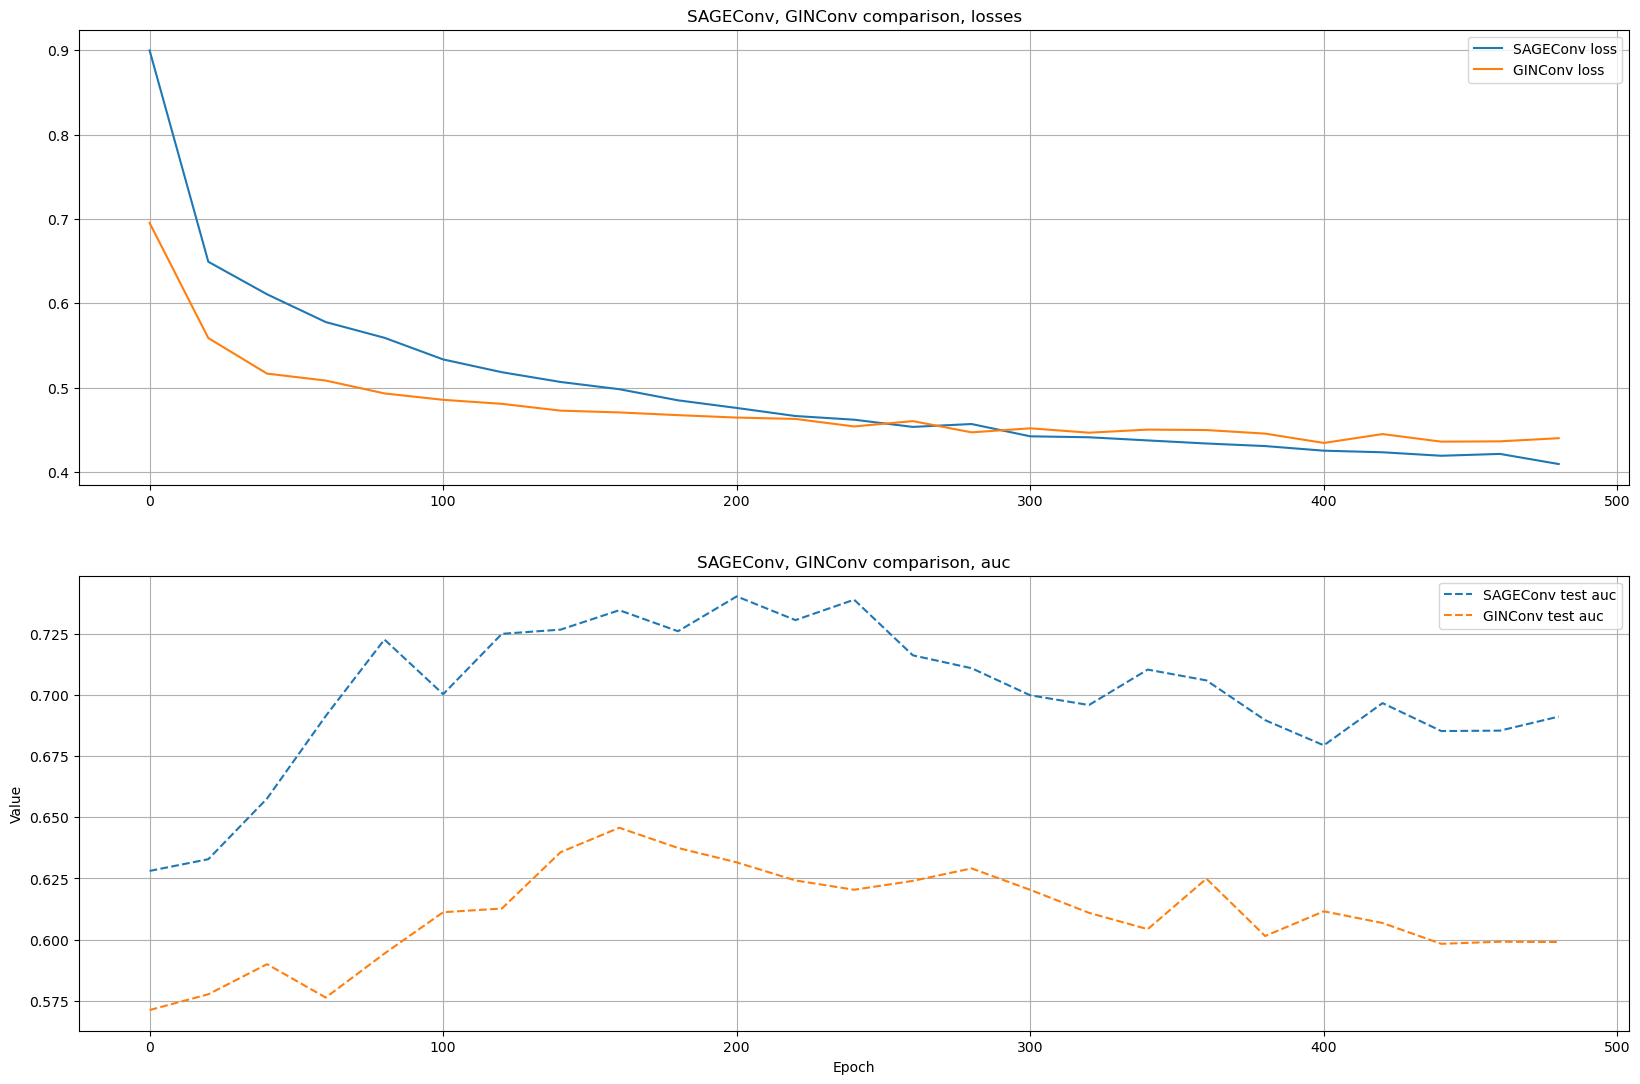

In [216]:
plot_loss_auc(epoch, {'labels': ['SAGEConv', 'GINConv'], 'losses': losses_, 'aucs': aucs_})

Видим, что для наших задач лучше подходит слой `SAGEConv`.

### Сравнение метрик на разных видах признаков

Перед дальнейшими экспериментами посмотрим, какие результаты показывает модель при использовании только одного типа признаков

In [119]:
epoch = 1000
losses_, aucs_ = [], []
feature_args = ['geo', 'act']
forward_args = [train_g, train_g.ndata['feat'], train_g.ndata['activity'], train_g.edata['weight']]
for feature_arg in feature_args:
    model = MODEL(
    geo_layer=SAGEConv, 
    in_feats_geo=train_g.ndata['feat'].shape[1], 
    h_feats_geo=16, 
    in_feats_act=train_g.ndata['activity'].shape[1], 
    h_feats_act=16
    )
    optimizer = torch.optim.Adam(model.parameters())
    pred = {'geo': DotPredictor(), 'act': EdgePred()}[feature_arg]
    _, losses, aucs = train(model,
                            forward_args+[feature_arg],   
                            epoch, 
                            train_pos_g, 
                            train_neg_g, 
                            test_pos_g,
                            test_neg_g,
                            optimizer, 
                            pred)
    losses_.append(losses)
    aucs_.append(aucs)

100%|██████████| 1000/1000 [03:40<00:00,  4.53it/s]


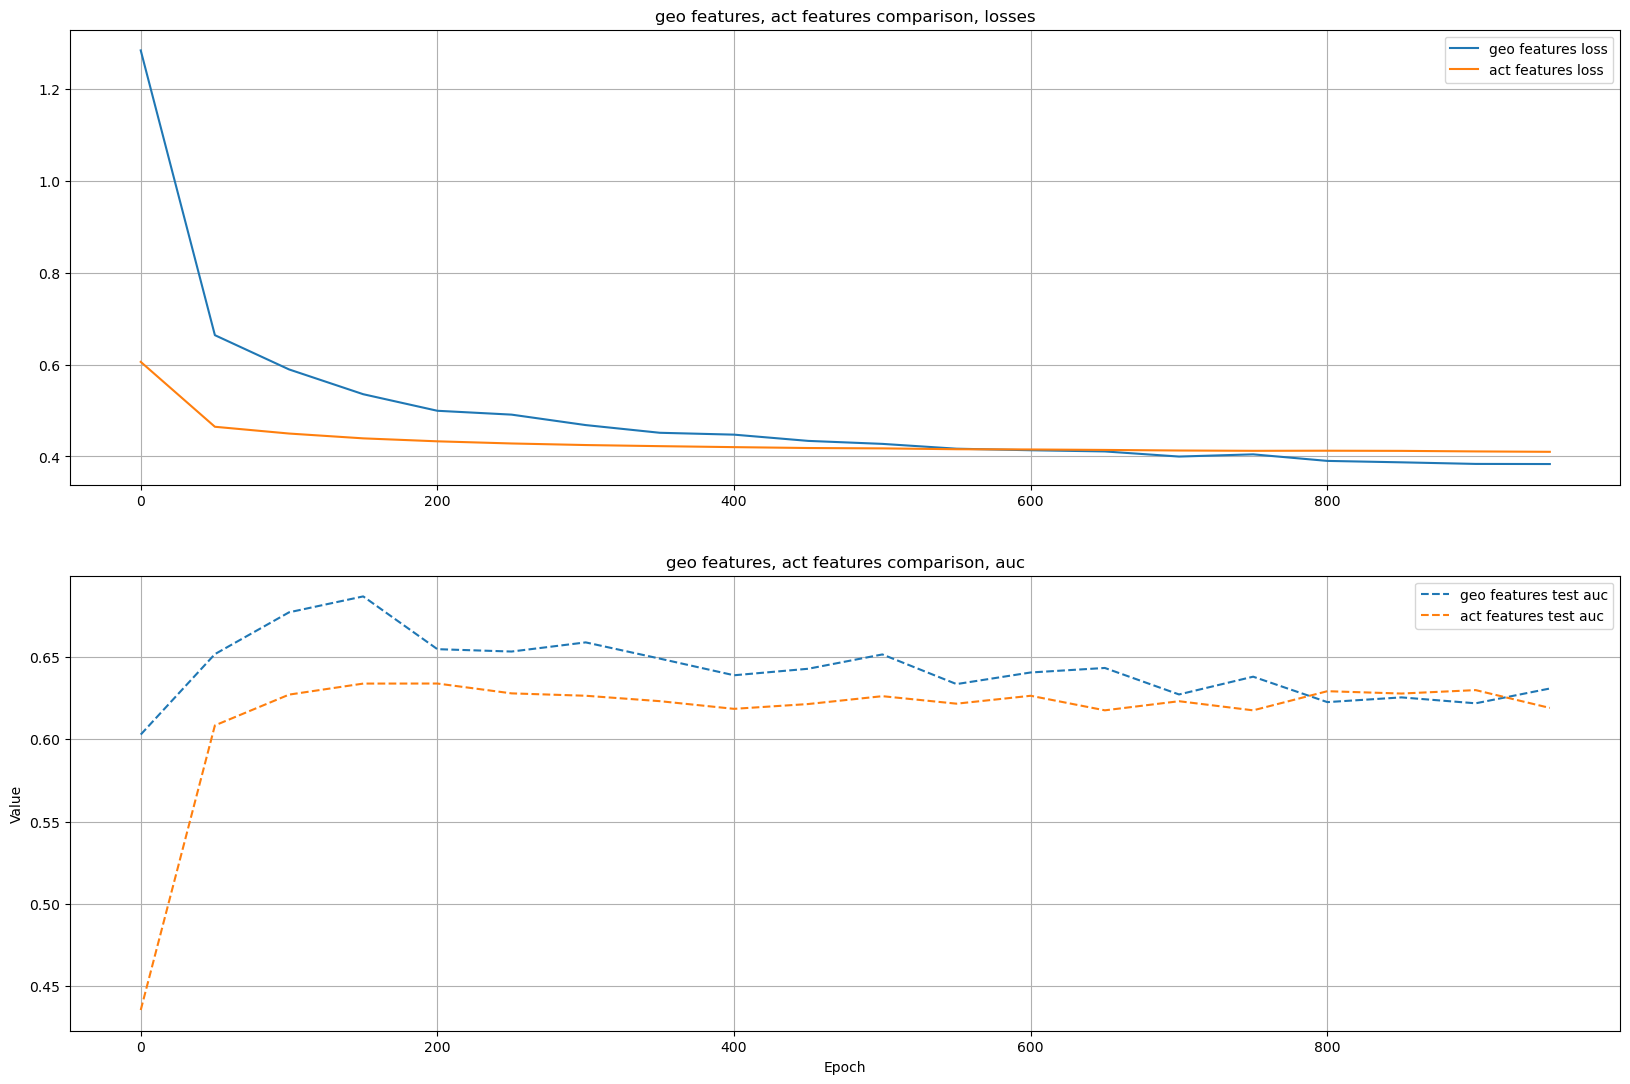

In [120]:
plot_loss_auc(epoch, {'labels': ['geo features', 'act features'], 'losses': losses_, 'aucs': aucs_})

### Агрегация признаков

Попробуем улучшить эффективность работы модели, агрегируя признаки

Нужно выбрать тип агрегации выходных результатов для различных признаков.\
Пусть у нас имеются два выхода:\
$h_1$ - тензор, результат обработки моделью признаков-эмбеддингов\
$h_2$ - тензор, результат обработки моделью признаков с координатами и ценой\
Возможно несколько вариантов:
1. направлять горизонтально объединенный тензор с выходами для обоих признаков сразу в predictor
$$ \overline{\underset{n\times m}{h_1}, \underset{n\times p}{h_2}} = \underset{n\times{m+p}}{h}\rightarrow predictor \rightarrow \underset{n\times 1}{pred}$$
2. обработать объединенный тензор дополнительным полносвязным слоем и направить в predictor
$$ \overline{\underset{n\times m}{h_1}, \underset{n\times p}{h_2}} = \underset{n\times{m+p}}{h}\rightarrow
\underset{n\times{m+p}\rightarrow n\times{h}}{f_\Theta(\underset{n\times{m+p}}{h})} \rightarrow predictor \rightarrow \underset{n\times 1}{pred}$$
3. сложить два тензора, задавая вклад для каждого тензора коэффициентом $\theta$ (коэффицент агреграции), и направить в predictor
$$\underset{n\times m}{h_1}, \underset{n\times p}{h_2} \rightarrow \theta \cdot \underset{n\times m}{h_1} + (1 - \theta) \cdot \underset{n\times p}{h_2} = h \rightarrow predictor \rightarrow \underset{n\times 1}{pred}$$
4. направить каждый тензор в predictor, а затем сложить два predictor, задавая вклад для каждого тензора коэффициентом $\theta$ (коэффицент агреграции)
$$\underset{n\times m}{h_1}, \underset{n\times p}{h_2} \rightarrow predictor \rightarrow \underset{n\times 1}{pred_{h_1}}, \underset{n\times 1}{pred_{h_2}} \rightarrow \underset{n\times 1}{\theta \cdot pred_{h_1}} + \underset{n\times 1}{(1 - \theta) \cdot pred_{h_2}} = \underset{n\times 1}{pred}$$

В последнем варианте предиктором для $h_1$ выступает $DotPredictor$, основанный на скалярном произведении:
$$\underset{n\times 1}{pred_{h_1}} = \underset{n\times p}{h_1} \cdot \underset{n\times p}{h_1}$$
Для $h_2$ предиктором выступает $EdgePredictor$, основанный на косинусном сходстве:
$$\underset{n\times 1}{pred_{h_2}} = \frac{h_{2_{src}} ^{T} h_{2_{dst}}}{{\| h_{2_{src}} \|} _2 \cdot {\| h_{2_{dst}} \|}_2} $$

In [117]:
losses_, aucs_ = [], []
epoch = 1000
pred = pred_geo = DotPredictor()
pred_act = EdgePred()
theta = 0.5
verbose = 20

# 1
model = MODEL(
    geo_layer=SAGEConv, 
    in_feats_geo=train_g.ndata['feat'].shape[1], 
    h_feats_geo=16, 
    in_feats_act=train_g.ndata['activity'].shape[1], 
    h_feats_act=16
    )
optimizer = torch.optim.Adam(model.parameters())
losses, aucs = [], []
for e in tqdm(range(epoch)):
    # forward
    h = model(train_g, train_g.ndata['feat'], train_g.ndata['activity'], train_g.edata['weight'], features='both')        
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % verbose == 0:
        with torch.no_grad():
            pos_score = pred(test_pos_g, h)
            neg_score = pred(test_neg_g, h)
            roc_auc = compute_auc(pos_score, neg_score)
            losses.append(loss.item())
            aucs.append(roc_auc)
losses_.append(losses)
aucs_.append(aucs)

# 2
model = MODEL(
    geo_layer=SAGEConv, 
    in_feats_geo=train_g.ndata['feat'].shape[1], 
    h_feats_geo=16, 
    in_feats_act=train_g.ndata['activity'].shape[1], 
    h_feats_act=16
    )
optimizer = torch.optim.Adam(model.parameters())
losses, aucs = [], []
for e in tqdm(range(epoch)):
    # forward
    h = nn.Linear(32, 16)(model(train_g, train_g.ndata['feat'], train_g.ndata['activity'], train_g.edata['weight']))       
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % verbose == 0:
        with torch.no_grad():
            pos_score = pred(test_pos_g, h)
            neg_score = pred(test_neg_g, h)
            roc_auc = compute_auc(pos_score, neg_score)
            losses.append(loss.item())
            aucs.append(roc_auc)
losses_.append(losses)
aucs_.append(aucs)

# 3
model = MODEL(
    geo_layer=SAGEConv, 
    in_feats_geo=train_g.ndata['feat'].shape[1], 
    h_feats_geo=16, 
    in_feats_act=train_g.ndata['activity'].shape[1], 
    h_feats_act=16
    )
optimizer = torch.optim.Adam(model.parameters())
losses, aucs = [], []
for e in tqdm(range(epoch)):
    # forward
    h1, h2 = model(train_g, train_g.ndata['feat'], train_g.ndata['activity'], train_g.edata['weight'], features='sep')     
    h = theta * h1 + (1 - theta) * h2   
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % verbose == 0:
        with torch.no_grad():
            pos_score = pred(test_pos_g, h)
            neg_score = pred(test_neg_g, h)
            roc_auc = compute_auc(pos_score, neg_score)
            losses.append(loss.item())
            aucs.append(roc_auc)
losses_.append(losses)
aucs_.append(aucs)

# 4
model = MODEL(
    geo_layer=SAGEConv, 
    in_feats_geo=train_g.ndata['feat'].shape[1], 
    h_feats_geo=16, 
    in_feats_act=train_g.ndata['activity'].shape[1], 
    h_feats_act=16
    )
optimizer = torch.optim.Adam(model.parameters())
losses, aucs = [], []
for e in tqdm(range(epoch)):
    # forward
    h1, h2 = model(train_g, train_g.ndata['feat'], train_g.ndata['activity'], train_g.edata['weight'], features='sep')        
    pos_score_act = pred_act(train_pos_g, h1)
    neg_score_act = pred_act(train_neg_g, h1)
    pos_score_geo = pred_geo(train_pos_g, h2)
    neg_score_geo = pred_geo(train_neg_g, h2)
    pos_score = theta * pos_score_act + (1 - theta) * pos_score_geo
    neg_score = theta * neg_score_act + (1 - theta) * neg_score_geo
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % verbose == 0:
        with torch.no_grad():
            pos_score_act = pred_act(test_pos_g, h1)
            neg_score_act = pred_act(test_neg_g, h1)
            pos_score_geo = pred_geo(test_pos_g, h2)
            neg_score_geo = pred_geo(test_neg_g, h2)
            pos_score = theta * pos_score_act + (1 - theta) * pos_score_geo
            neg_score = theta * neg_score_act + (1 - theta) * neg_score_geo
            roc_auc = compute_auc(pos_score, neg_score)
            losses.append(loss.item())
            aucs.append(roc_auc)
losses_.append(losses)
aucs_.append(aucs)

100%|██████████| 1000/1000 [04:37<00:00,  3.60it/s]


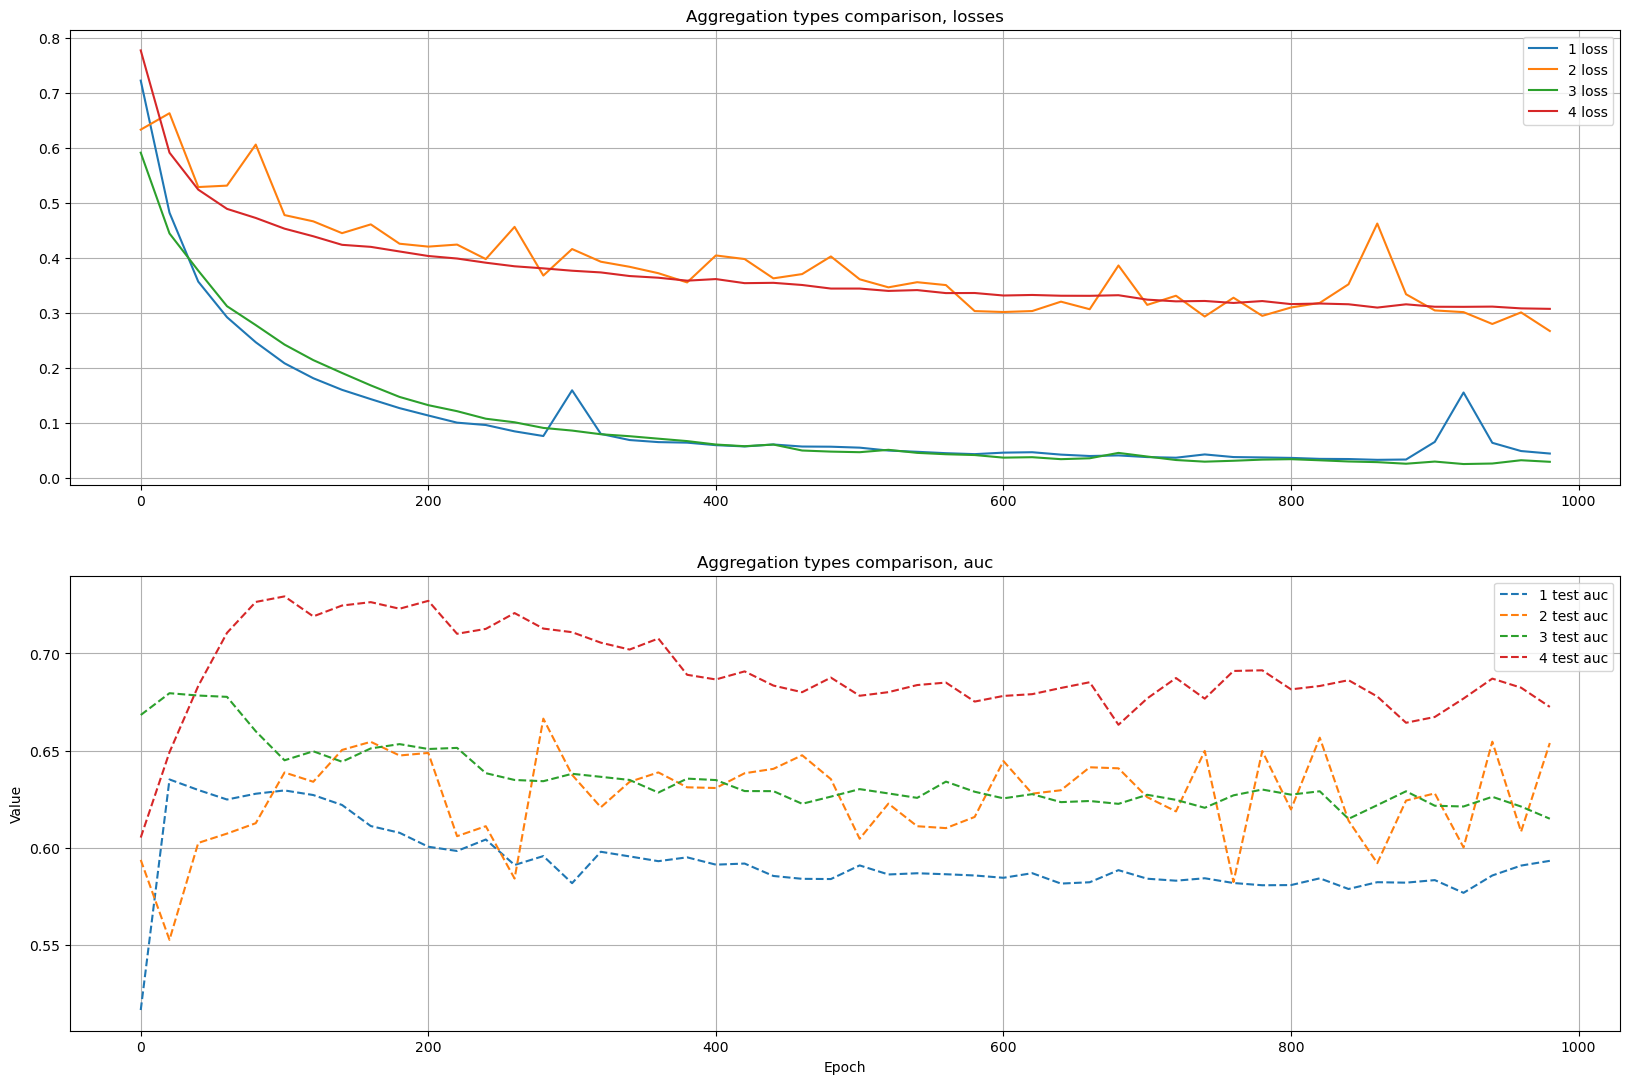

In [118]:
plot_loss_auc(epoch, {'labels': ['1', '2', '3', '4'], 'losses': losses_, 'aucs': aucs_},
              title='Aggregation types comparison')

Видно, что лучше всего сработал последний вариант: направить каждый тензор в prediction, а затем сложить два prediction, задавая вклад для каждого тензора коэффициентом $\theta$

### Выбор значения коэффицента агрегации

Исследуем зависимость значения метрик от значения параметра $\theta$

In [121]:
losses_, aucs_ = [], []
thetas = [0.1, 0.3, 0.5, 0.7, 0.9]
epoch = 1000
verbose = 20
for theta in thetas:
    losses, aucs = [], []
    pred_act = EdgePred()
    pred_geo = DotPredictor()
    model = MODEL(
    geo_layer=SAGEConv, 
    in_feats_geo=train_g.ndata['feat'].shape[1], 
    h_feats_geo=16, 
    in_feats_act=train_g.ndata['activity'].shape[1], 
    h_feats_geo=16
    )
    optimizer = torch.optim.Adam(model.parameters())
    for e in tqdm(range(epoch)):
        # forward
        h1, h2 = model(train_g, train_g.ndata['feat'], train_g.ndata['activity'], train_g.edata['weight'], features='sep')        
        pos_score_act = pred_act(train_pos_g, h1)
        neg_score_act = pred_act(train_neg_g, h1)
        pos_score_geo = pred_geo(train_pos_g, h2)
        neg_score_geo = pred_geo(train_neg_g, h2)
        pos_score = theta * pos_score_act + (1 - theta) * pos_score_geo
        neg_score = theta * neg_score_act + (1 - theta) * neg_score_geo
        loss = compute_loss(pos_score, neg_score)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % verbose == 0:
            with torch.no_grad():
                pos_score_act = pred_act(test_pos_g, h1)
                neg_score_act = pred_act(test_neg_g, h1)
                pos_score_geo = pred_geo(test_pos_g, h2)
                neg_score_geo = pred_geo(test_neg_g, h2)
                pos_score = theta * pos_score_act + (1 - theta) * pos_score_geo
                neg_score = theta * neg_score_act + (1 - theta) * neg_score_geo
                roc_auc = compute_auc(pos_score, neg_score)
                losses.append(loss.item())
                aucs.append(roc_auc)
    losses_.append(losses)
    aucs_.append(aucs)

100%|██████████| 1000/1000 [04:25<00:00,  3.77it/s]


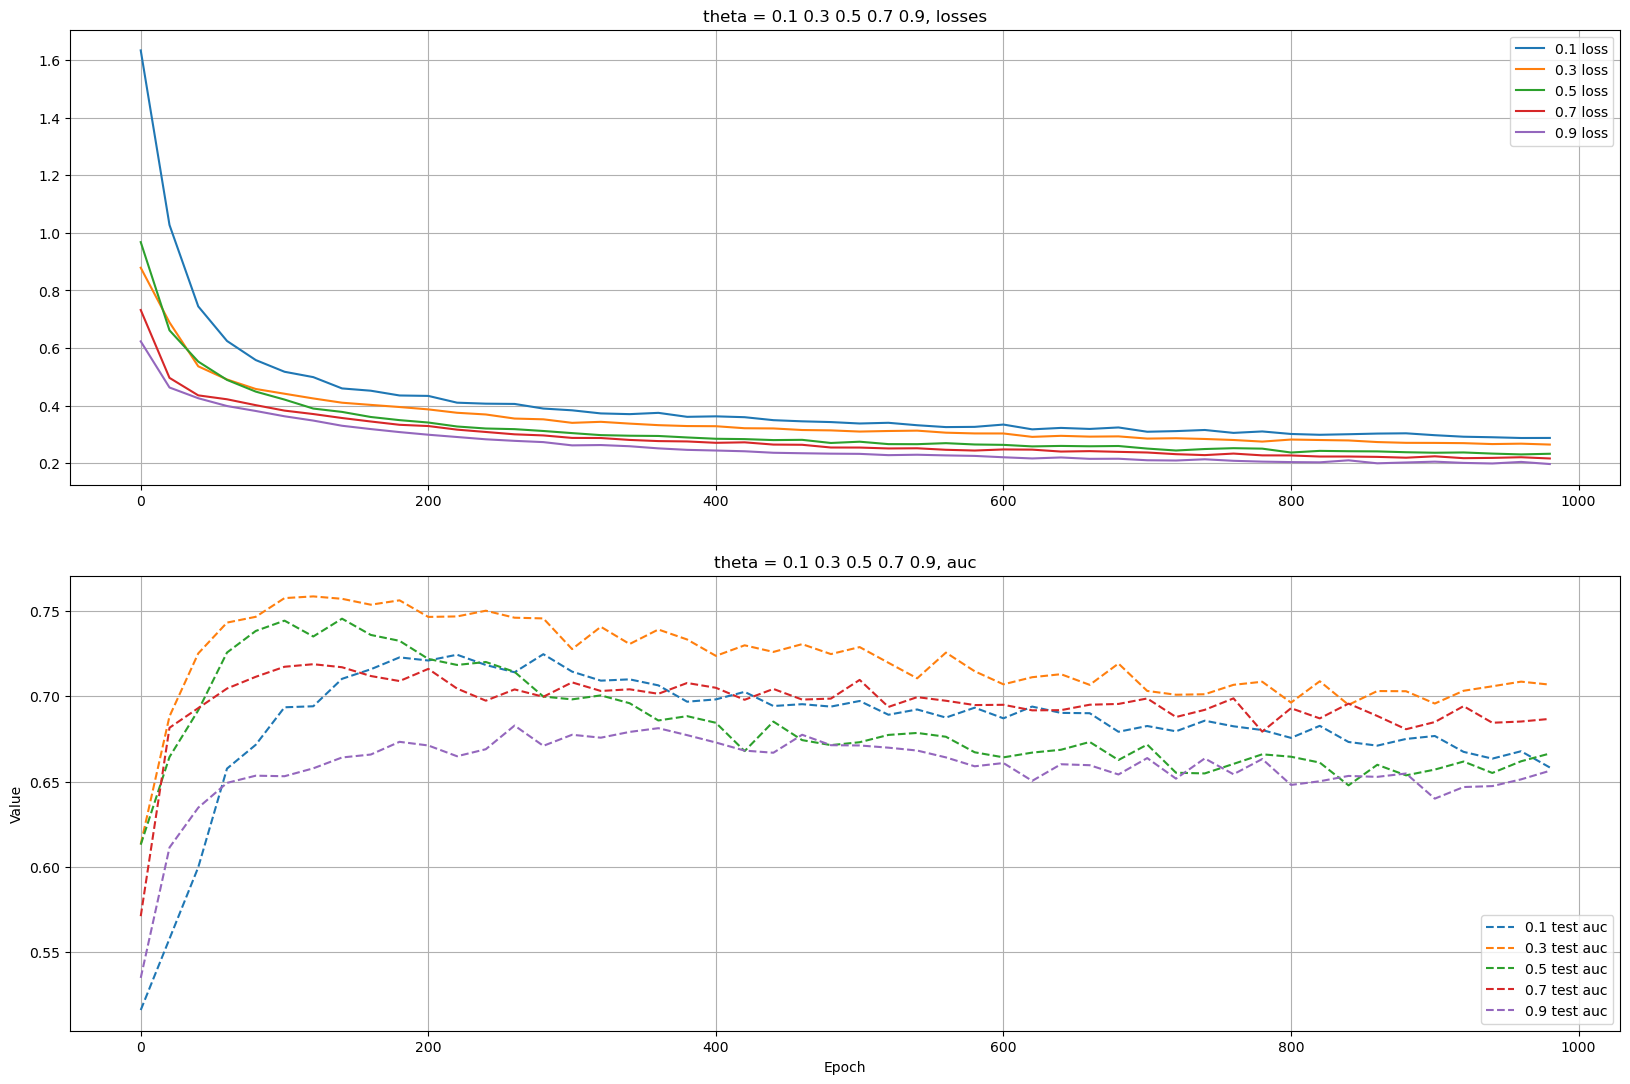

In [99]:
plot_loss_auc(epoch, 
              {
                  'labels': list(map(str, thetas)), 
                  'losses': losses_, 
                  'aucs': aucs_},
            title=f'theta = {" ".join(list(map(str, thetas)))}'
            )

Видно, что при $\theta \approx 0.3$ модель наиболее эффективна

### Выбор оптимального размера скрытых слоев

Далее есть смысл проверить зависимость результатов обучения от размера скрытых слоев `h_feats_geo` и `h_feats_act`

In [123]:
h_feats = [16, 64, 128]
h_feats_combs = list(
        set(
            permutations(h_feats, 2)) 
        | 
        set(
            combinations_with_replacement(h_feats, 2)
            )
        )

models = [MODEL(
    geo_layer=SAGEConv, 
    in_feats_geo=train_g.ndata['feat'].shape[1], 
    h_feats_geo=h_feats_geo, 
    in_feats_act=train_g.ndata['activity'].shape[1], 
    h_feats_act=h_feats_act
    )
    for (h_feats_geo, h_feats_act) in h_feats_combs
]

losses_, aucs_ = [], []
epoch = 1000
verbose = 20
theta = 0.3
for model in models:
    losses, aucs = [], []
    pred_act = EdgePred()
    pred_geo = DotPredictor()
    optimizer = torch.optim.Adam(model.parameters())
    for e in tqdm(range(epoch)):
        # forward
        h1, h2 = model(train_g, train_g.ndata['feat'], train_g.ndata['activity'], train_g.edata['weight'], features='sep')        
        pos_score_act = pred_act(train_pos_g, h1)
        neg_score_act = pred_act(train_neg_g, h1)
        pos_score_geo = pred_geo(train_pos_g, h2)
        neg_score_geo = pred_geo(train_neg_g, h2)
        pos_score = theta * pos_score_act + (1 - theta) * pos_score_geo
        neg_score = theta * neg_score_act + (1 - theta) * neg_score_geo
        loss = compute_loss(pos_score, neg_score)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % verbose == 0:
            with torch.no_grad():
                pos_score_act = pred_act(test_pos_g, h1)
                neg_score_act = pred_act(test_neg_g, h1)
                pos_score_geo = pred_geo(test_pos_g, h2)
                neg_score_geo = pred_geo(test_neg_g, h2)
                pos_score = theta * pos_score_act + (1 - theta) * pos_score_geo
                neg_score = theta * neg_score_act + (1 - theta) * neg_score_geo
                roc_auc = compute_auc(pos_score, neg_score)
                losses.append(loss.item())
                aucs.append(roc_auc)
    losses_.append(losses)
    aucs_.append(aucs)

100%|██████████| 1000/1000 [06:11<00:00,  2.69it/s]


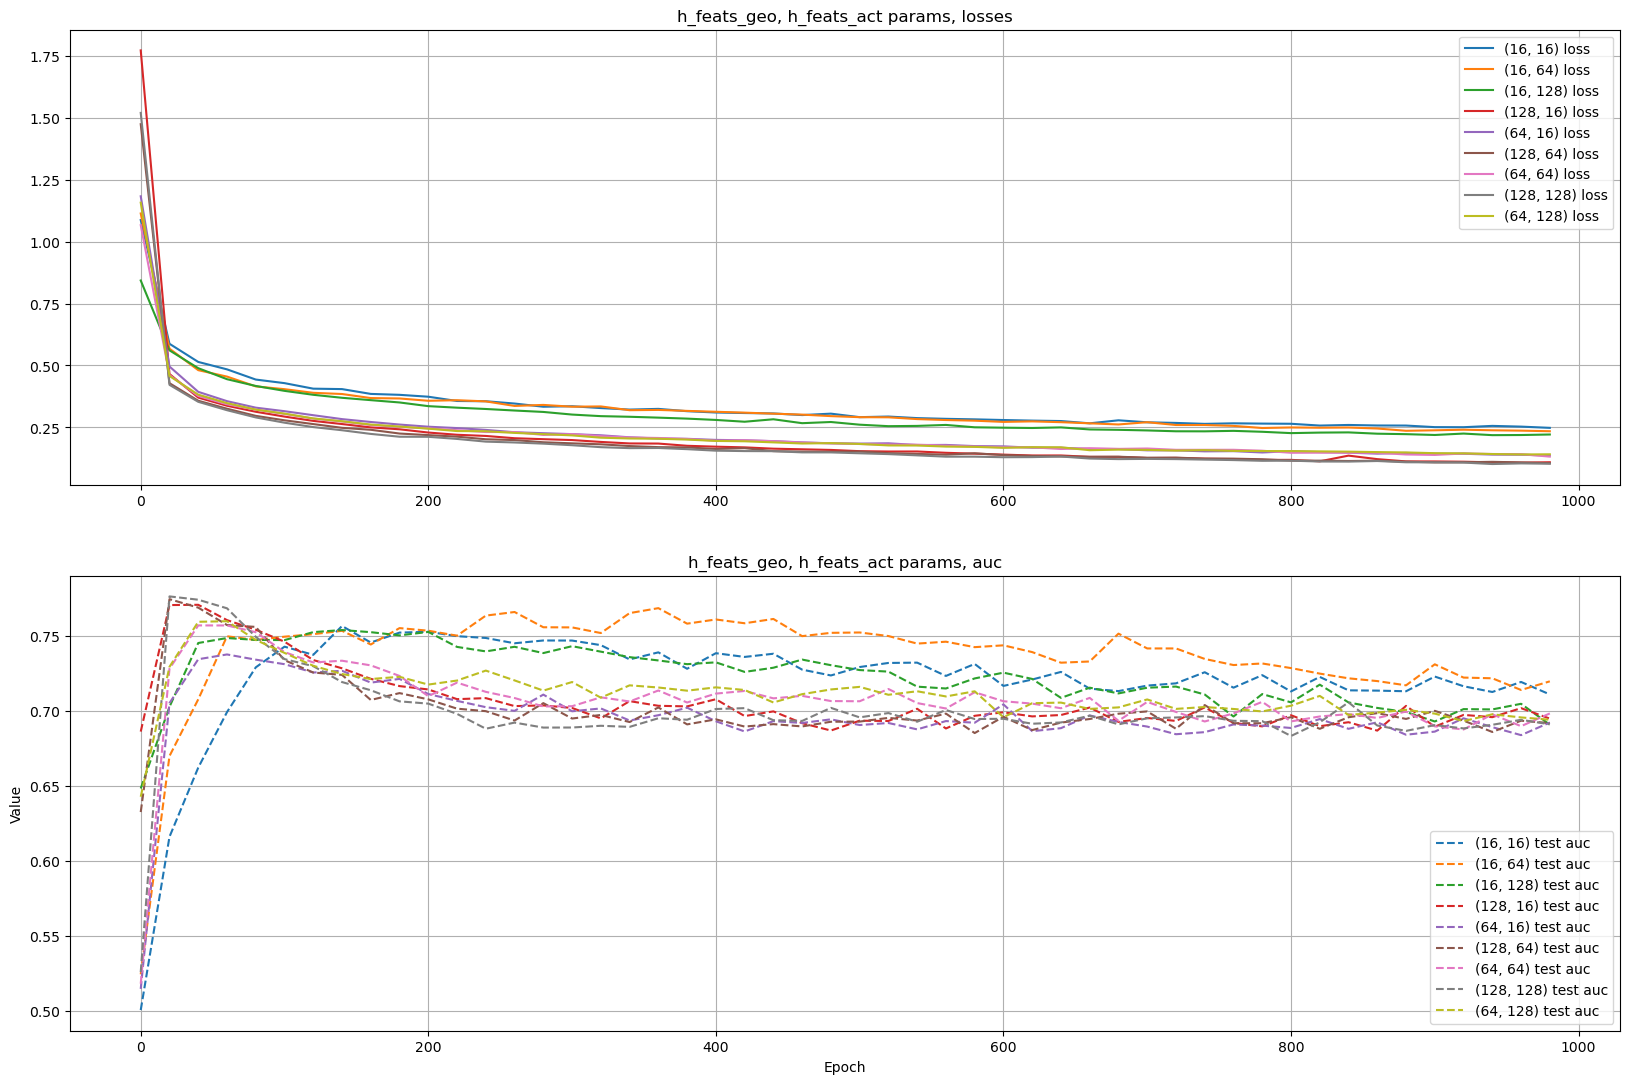

In [318]:
plot_loss_auc(
    epoch, 
    {'labels': list(map(str, h_feats_combs)), 'losses': losses_, 'aucs': aucs_},
    title='h_feats_geo, h_feats_act params')  

Как видно по графикам, оптимальными параметрами являются `h_feats_geo = 16` и `h_feats_act = 64`

### Выбор оптимального количества слоев

Исследуем значения метрик от количества слоев в модели

In [129]:
layers = [2, 3, 5]
layers_combs = get_combs(layers, 2)
losses_, aucs_ = [], []
epoch = 1000
verbose = 20
theta = 0.3
models = [MODEL(
    geo_layer=SAGEConv, 
    in_feats_geo=train_g.ndata['feat'].shape[1], 
    h_feats_geo=16, 
    in_feats_act=train_g.ndata['activity'].shape[1], 
    h_feats_act=64,
    num_geo_layers=layers_comb[0],
    num_act_layers=layers_comb[1],
    )
    for layers_comb in layers_combs
    ]
for model in models:
    losses, aucs = [], []
    pred_act = EdgePred()
    pred_geo = DotPredictor()
    optimizer = torch.optim.Adam(model.parameters())
    for e in tqdm(range(epoch)):
        # forward
        h1, h2 = model(train_g, train_g.ndata['feat'], train_g.ndata['activity'], train_g.edata['weight'], features='sep')        
        pos_score_act = pred_act(train_pos_g, h1)
        neg_score_act = pred_act(train_neg_g, h1)
        pos_score_geo = pred_geo(train_pos_g, h2)
        neg_score_geo = pred_geo(train_neg_g, h2)
        pos_score = theta * pos_score_act + (1 - theta) * pos_score_geo
        neg_score = theta * neg_score_act + (1 - theta) * neg_score_geo
        loss = compute_loss(pos_score, neg_score)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % verbose == 0:
            with torch.no_grad():
                pos_score_act = pred_act(test_pos_g, h1)
                neg_score_act = pred_act(test_neg_g, h1)
                pos_score_geo = pred_geo(test_pos_g, h2)
                neg_score_geo = pred_geo(test_neg_g, h2)
                pos_score = theta * pos_score_act + (1 - theta) * pos_score_geo
                neg_score = theta * neg_score_act + (1 - theta) * neg_score_geo
                roc_auc = compute_auc(pos_score, neg_score)
                losses.append(loss.item())
                aucs.append(roc_auc)
    losses_.append(losses)
    aucs_.append(aucs)

100%|██████████| 1000/1000 [08:25<00:00,  1.98it/s]


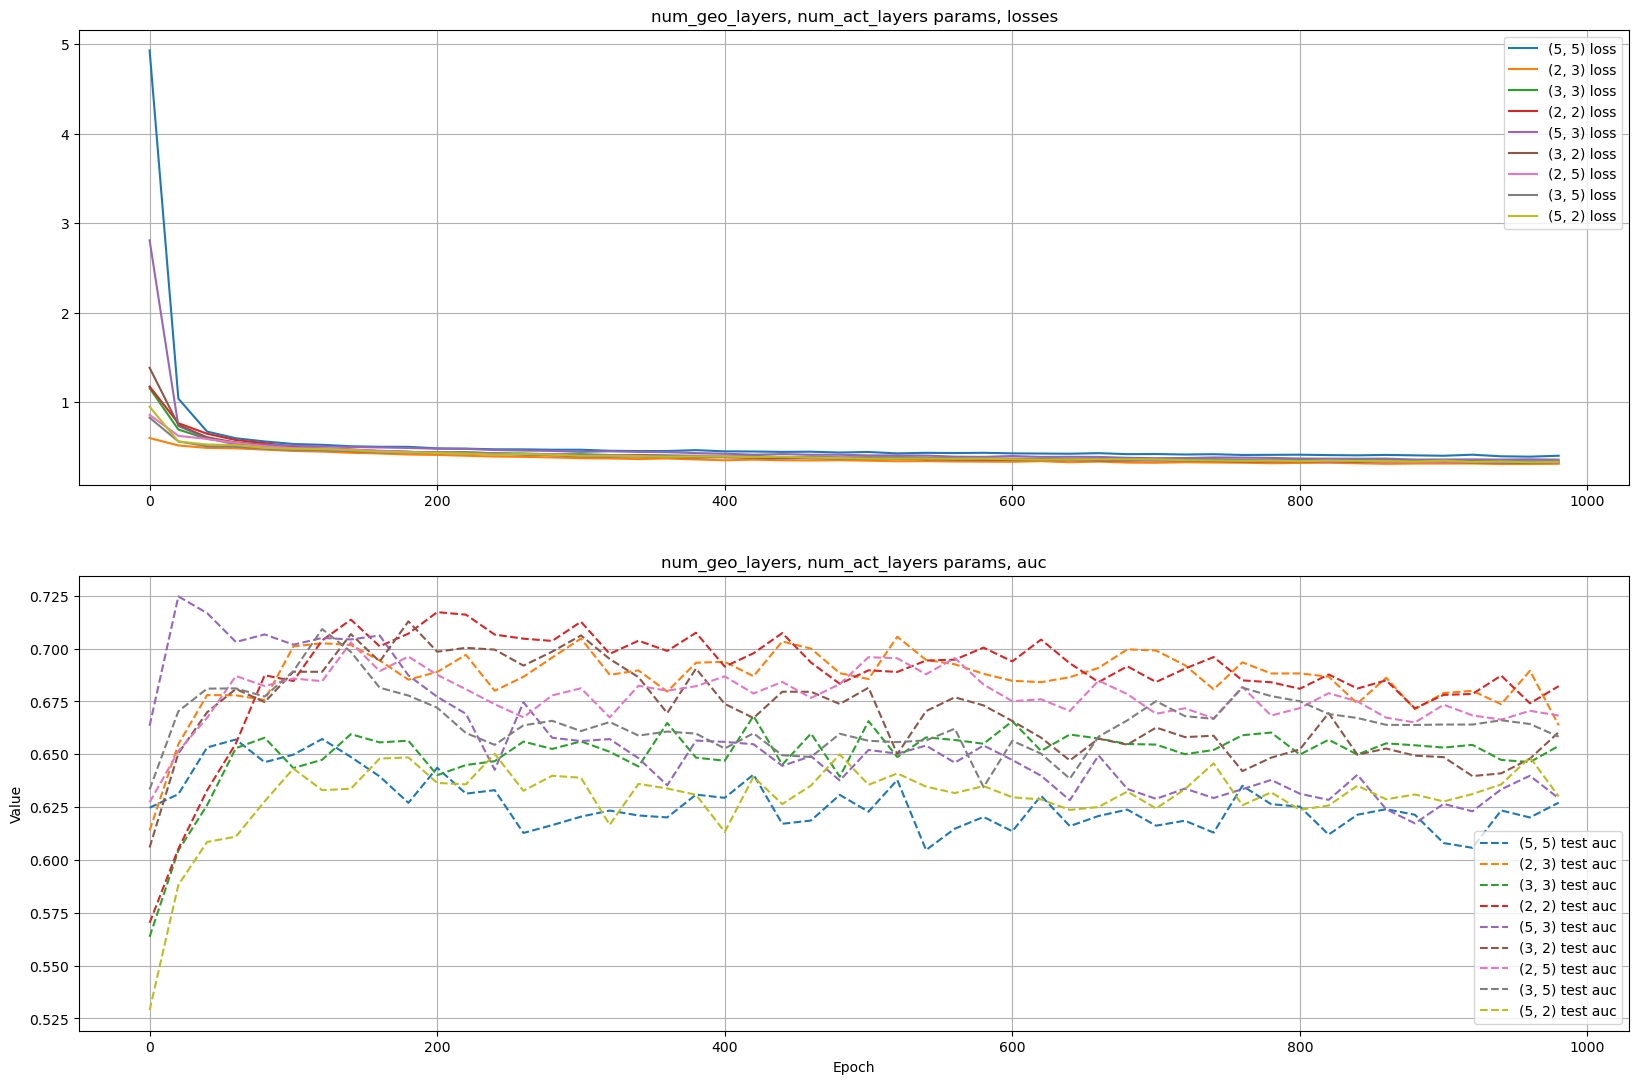

In [130]:
plot_loss_auc(
    epoch, 
    {'labels': list(map(str, layers_combs)), 'losses': losses_, 'aucs': aucs_},
    title='num_geo_layers, num_act_layers params')   

Видно, что модель покзывает лучшие результаты с параметрами `num_act_layers = 2` и `num_geo_layers = 2`

### Выбор функции активации

Исследуем зависимость результатов обучения от вида функции активации.\
Используемые функции активации:

1. **SiLU** (Sigmoid Linear Unit)\
SiLU, также известная как Swish, определяется следующим образом:

$$ \text{SiLU}(x) = x \cdot \sigma(x) = x \cdot \frac{1}{1 + e^{-x}} $$

где $\sigma(x)$ — это сигмовидная функция.

2. **ReLU** (Rectified Linear Unit)\
ReLU является одной из самых популярных функций активации и определяется следующим образом:

$$ \text{ReLU}(x) = \max(0, x) $$

3. **Leaky ReLU**
Leaky ReLU модифицирует стандартный ReLU, добавляя небольшую наклонность для отрицательных значений:

$$ \text{Leaky ReLU}(x) = \begin{cases} 
x, & \text{if } x \geq 0 \\
\alpha x, & \text{if } x < 0 
\end{cases} $$

где $\alpha$ — небольшое положительное значение (обычно 0.01).

4. **ELU** (Exponential Linear Unit)\
ELU улучшает обучение путем использования экспоненциального сглаживания для отрицательных значений:

$$ \text{ELU}(x) = \begin{cases} 
x, & \text{if } x \geq 0 \\
\alpha (e^x - 1), & \text{if } x < 0 
\end{cases} $$

где $\alpha$ — гиперпараметр.

5. **GELU** (Gaussian Error Linear Unit)\
GELU представляет собой комбинацию нелинейности и вероятностной функции, которая выглядит следующим образом:

$$ \text{GELU}(x) = x \cdot \Phi(x) = x \cdot \frac{1}{2} \left[ 1 + \text{erf} \left( \frac{x}{\sqrt{2}} \right) \right] $$

где $\Phi(x)$ — функция распределения стандартного нормального распределения, а $\text{erf}$ — функция ошибок.

6. **Tanh** (Hyperbolic Tangent)\
Функция гиперболического тангенса представлена следующим образом:

$$ \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} $$

7. **Sigmoid**\
Сигмовидная функция преобразует значения в диапазон от 0 до 1:

$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

8. **CELU** (Continuously Differentiable Exponential Linear Unit)\
CELU является непрерывно дифференцируемым вариантом ELU:

$$ \text{CELU}(x) = \begin{cases} 
x, & \text{if } x \geq 0 \\
\alpha (e^{x/\alpha} - 1), & \text{if } x < 0 
\end{cases} $$

9. **SELU** (Scaled Exponential Linear Unit)\
SELU автоматически нормализует активации и является масштабированной версией ELU:

$$ \text{SELU}(x) = \lambda \begin{cases} 
x, & \text{if } x \geq 0 \\
\alpha (e^x - 1), & \text{if } x < 0 
\end{cases} $$

где $\lambda$ и $\alpha$ — заранее определенные константы (обычно $\lambda \approx 1.0507$ и $\alpha \approx 1.67326$).


In [138]:
activation_funcs = [F.silu, F.relu, F.leaky_relu, F.elu, F.gelu, F.tanh, F.sigmoid, F.celu, F.selu]
losses_, aucs_ = [], []
epoch = 1000
verbose = 20
theta = 0.3
models = [MODEL(
    geo_layer=SAGEConv, 
    in_feats_geo=train_g.ndata['feat'].shape[1], 
    h_feats_geo=16, 
    in_feats_act=train_g.ndata['activity'].shape[1], 
    h_feats_act=64,
    num_geo_layers=2,
    num_act_layers=3,
    activation=activation_func
    )
    for activation_func in activation_funcs
    ]
for model in models:
    losses, aucs = [], []
    pred_act = EdgePred()
    pred_geo = DotPredictor()
    optimizer = torch.optim.Adam(model.parameters())
    for e in tqdm(range(epoch)):
        # forward
        h1, h2 = model(train_g, train_g.ndata['feat'], train_g.ndata['activity'], train_g.edata['weight'], features='sep')        
        pos_score_act = pred_act(train_pos_g, h1)
        neg_score_act = pred_act(train_neg_g, h1)
        pos_score_geo = pred_geo(train_pos_g, h2)
        neg_score_geo = pred_geo(train_neg_g, h2)
        pos_score = theta * pos_score_act + (1 - theta) * pos_score_geo
        neg_score = theta * neg_score_act + (1 - theta) * neg_score_geo
        loss = compute_loss(pos_score, neg_score)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % verbose == 0:
            with torch.no_grad():
                pos_score_act = pred_act(test_pos_g, h1)
                neg_score_act = pred_act(test_neg_g, h1)
                pos_score_geo = pred_geo(test_pos_g, h2)
                neg_score_geo = pred_geo(test_neg_g, h2)
                pos_score = theta * pos_score_act + (1 - theta) * pos_score_geo
                neg_score = theta * neg_score_act + (1 - theta) * neg_score_geo
                roc_auc = compute_auc(pos_score, neg_score)
                losses.append(loss.item())
                aucs.append(roc_auc)
    losses_.append(losses)
    aucs_.append(aucs)

100%|██████████| 1000/1000 [06:15<00:00,  2.66it/s]


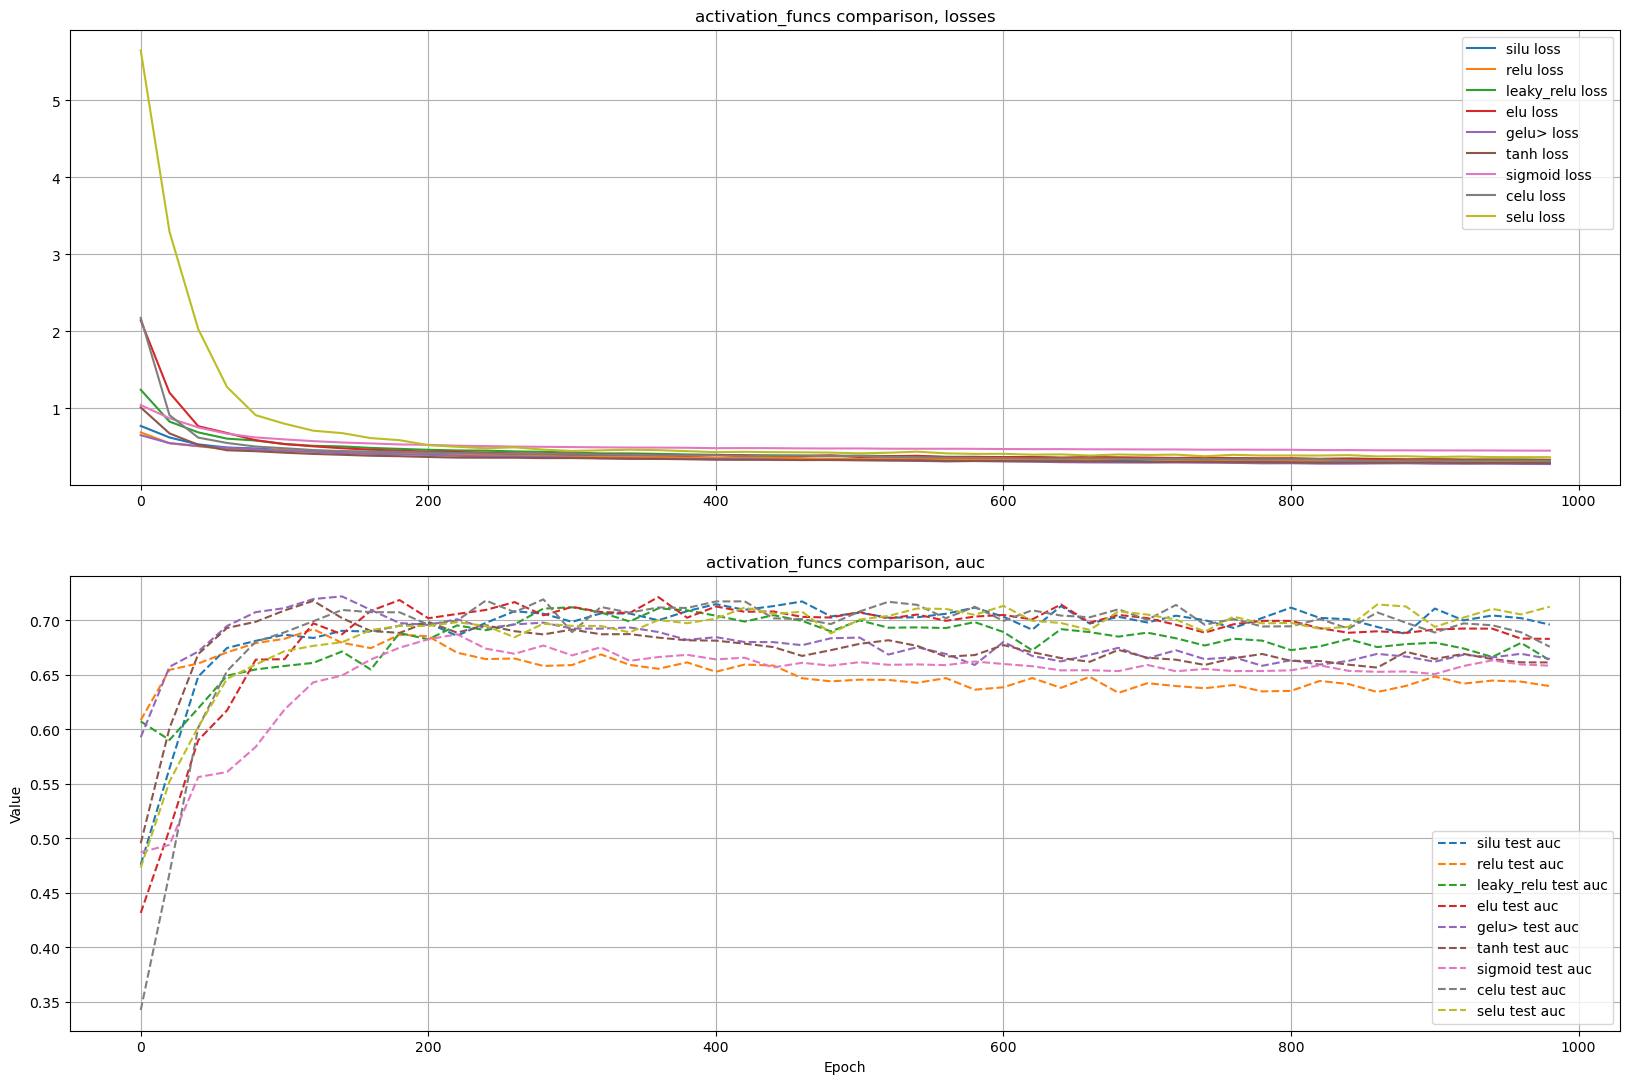

In [143]:
plot_loss_auc(
    epoch, 
    {'labels': list(map(lambda x: str(x).split('function ')[1].split(' ')[0], activation_funcs)), 'losses': losses_, 'aucs': aucs_},
    title='activation_funcs comparison')   

Лучшей функцией активации среди рассматриваемых оказалась **SiLU** (Sigmoid Linear Unit):

$$ \text{SiLU}(x) = x \cdot \sigma(x) = x \cdot \frac{1}{1 + e^{-x}} $$

где $\sigma(x)$ — это сигмовидная функция.

### Выбор оптимизатора

Следующим шагом выберем оптимизатор для нашей модели. Использованные варианты:
1. **Adam** (Adaptive Moment Estimation)
Adam объединяет преимущества двух других методов: AdaGrad и RMSProp. Он использует адаптивные скорости обучения для каждого параметра.

Формулы для обновления весов:

\begin{align*}
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t} \\
\hat{v}_t &= \frac{v_t}{1 - \beta_2^t} \\
\theta_t &= \theta_{t-1} - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
\end{align*}

где:
- $g_t$ — градиент на шаге $t$,
- $m_t$ и $v_t$ — моменты первого и второго порядка соответственно,
- $\beta_1$ и $\beta_2$ — коэффициенты затухания,
- $\eta$ — скорость обучения,
- $\epsilon$ — маленькое число для численной стабильности.

2. **Adagrad** (Adaptive Gradient Algorithm)
Adagrad адаптирует скорость обучения для каждого параметра на основе частоты его обновления. Параметры, которые обновляются часто, имеют меньшую скорость обучения.

Формула обновления весов:

\begin{align*}
G_t &= G_{t-1} + g_t^2 \\
\theta_t &= \theta_{t-1} - \frac{\eta}{\sqrt{G_t} + \epsilon} g_t
\end{align*}

где:
- $G_t$ — сумма квадратов градиентов до шага $t$,
- $g_t$ — градиент на шаге $t$,
- $\eta$ — начальная скорость обучения,
- $\epsilon$ — маленькое число для численной стабильности.

3. **RMSprop** (Root Mean Square Propagation)
RMSprop модифицирует Adagrad путем введения экспоненциального среднего квадрата градиентов для нормализации скорости обучения.

Формула обновления весов:

\begin{align*}
E[g^2]_t &= \rho E[g^2]_{t-1} + (1 - \rho) g_t^2 \\
\theta_t &= \theta_{t-1} - \frac{\eta}{\sqrt{E[g^2]_t} + \epsilon} g_t
\end{align*}

где:
- $E[g^2]_t$ — экспоненциальное скользящее среднее квадрата градиентов,
- $\rho$ — коэффициент затухания,
- $\eta$ — скорость обучения,
- $\epsilon$ — маленькое число для численной стабильности.

4. **SGD** (Stochastic Gradient Descent)
SGD обновляет параметры модели в направлении отрицательного градиента функции потерь. Для улучшения сходимости часто добавляют импульс (momentum).

Формулы для обновления весов с импульсом:

\begin{align*}
v_t &= \mu v_{t-1} - \eta g_t \\
\theta_t &= \theta_{t-1} + v_t
\end{align*}

где:
- $g_t$ — градиент на шаге $t$,
- $v_t$ — импульс,
- $\mu$ — коэффициент импульса,
- $\eta$ — скорость обучения.

5. **NAdam** (Nesterov-accelerated Adaptive Moment Estimation)
NAdam объединяет идеи Adam и Nesterov Momentum, чтобы улучшить скорость сходимости и стабильность.

Формулы для обновления весов:

\begin{align*}
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t} \\
\hat{v}_t &= \frac{v_t}{1 - \beta_2^t} \\
\theta_t &= \theta_{t-1} - \eta \left( \frac{\beta_1 \hat{m}_t + (1 - \beta_1) g_t}{\sqrt{\hat{v}_t} + \epsilon} \right)
\end{align*}

где:
- $g_t$ — градиент на шаге $t$,
- $m_t$ и $v_t$ — моменты первого и второго порядка соответственно,
- $\beta_1$ и $\beta_2$ — коэффициенты затухания,
- $\eta$ — скорость обучения,
- $\epsilon$ — маленькое число для численной стабильности.


In [149]:
losses_, aucs_ = [], []
epoch = 1000
verbose = 20
theta = 0.3
optimizers = [
    torch.optim.Adam,
    torch.optim.Adagrad,
    torch.optim.RMSprop,
    torch.optim.SGD,
    torch.optim.NAdam,
]
for optimizer in optimizers:
    model = MODEL(
        geo_layer=SAGEConv, 
        in_feats_geo=train_g.ndata['feat'].shape[1], 
        h_feats_geo=16, 
        in_feats_act=train_g.ndata['activity'].shape[1], 
        h_feats_act=64, 
        num_geo_layers=2, 
        num_act_layers=3, 
        activation=F.silu
        )
    losses, aucs = [], []
    pred_act = EdgePred()
    pred_geo = DotPredictor()
    optimizer = optimizer(model.parameters(), lr=0.001)
    for e in tqdm(range(epoch)):
        # forward
        h1, h2 = model(train_g, train_g.ndata['feat'], train_g.ndata['activity'], train_g.edata['weight'], features='sep')        
        pos_score_act = pred_act(train_pos_g, h1)
        neg_score_act = pred_act(train_neg_g, h1)
        pos_score_geo = pred_geo(train_pos_g, h2)
        neg_score_geo = pred_geo(train_neg_g, h2)
        pos_score = theta * pos_score_act + (1 - theta) * pos_score_geo
        neg_score = theta * neg_score_act + (1 - theta) * neg_score_geo
        loss = compute_loss(pos_score, neg_score)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % verbose == 0:
            with torch.no_grad():
                pos_score_act = pred_act(test_pos_g, h1)
                neg_score_act = pred_act(test_neg_g, h1)
                pos_score_geo = pred_geo(test_pos_g, h2)
                neg_score_geo = pred_geo(test_neg_g, h2)
                pos_score = theta * pos_score_act + (1 - theta) * pos_score_geo
                neg_score = theta * neg_score_act + (1 - theta) * neg_score_geo
                roc_auc = compute_auc(pos_score, neg_score)
                losses.append(loss.item())
                aucs.append(roc_auc)
    losses_.append(losses)
    aucs_.append(aucs)

100%|██████████| 1000/1000 [06:04<00:00,  2.74it/s]


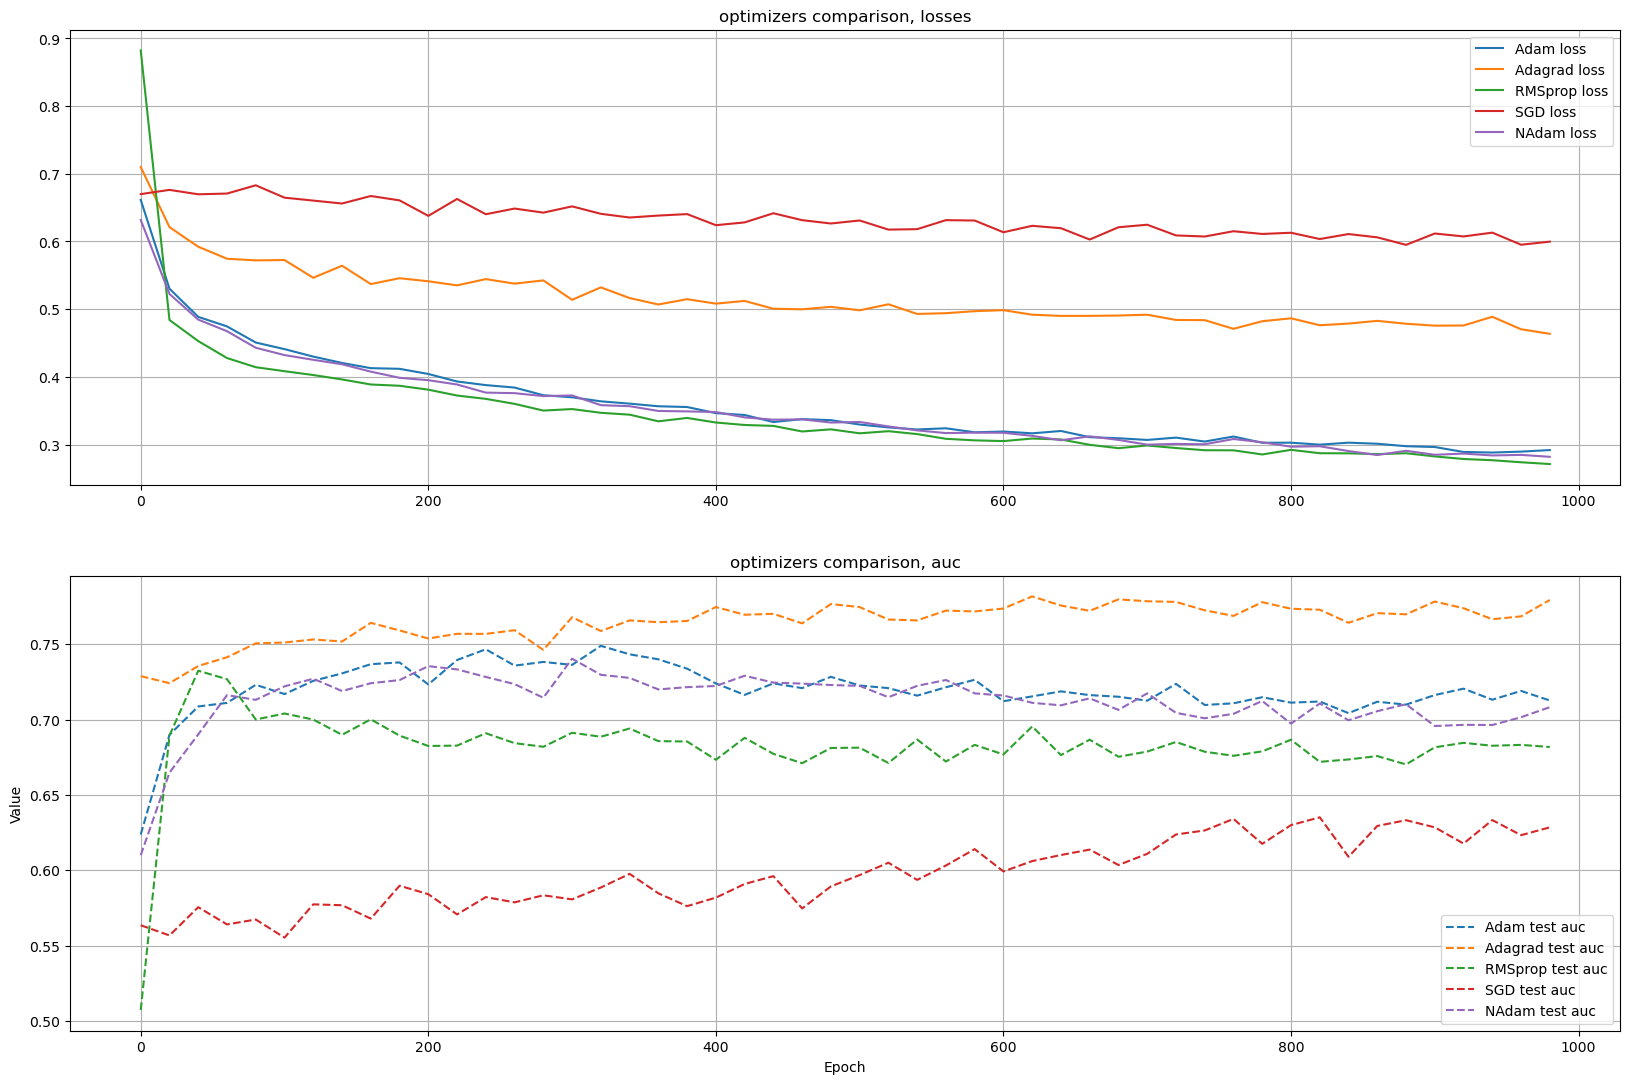

In [152]:
plot_loss_auc(
    epoch, 
    {'labels': list(map(lambda x: str(x).split('.')[-1].split("'")[0], optimizers)), 'losses': losses_, 'aucs': aucs_},
    title='optimizers comparison')   

Анализируя график видно, что результат лучше всего при применении оптимизатора `Adagrad`

### Настройка оптимизатора

Перед настройкой параметров оптимизатора ознакомимся с некоторыми из них:
1. **Learning Rate** (скорость обучения)

Это основной гиперпараметр, который определяет величину шага при обновлении параметров модели.

По умолчанию: `lr = 0.01`


2. **Initial Accumulator Value** (начальное значение градиента)

Этот параметр определяет начальное значение для каждого элемента в векторе накопленных градиентов.

По умолчанию: `initial_accumulator_value = 0`


3. **Weight Decay** (регуляризация)

Этот параметр помогает предотвратить переобучение, добавляя штраф за большие значения весов.

По умолчанию: `weight_decay = 0`

In [166]:
optimizer_params = {
    'lr': [0.001, 0.01],
    'initial_accumulator_value': [0, 0.1],
    'weight_decay': [0, 1e-3]
}
optimizer_params_grid = list(ParameterGrid(optimizer_params))
losses_, aucs_ = [], []
epoch = 1000
verbose = 20
theta = 0.3
for optimizer_params in optimizer_params_grid:
    model = MODEL(
        geo_layer=SAGEConv, 
        in_feats_geo=train_g.ndata['feat'].shape[1], 
        h_feats_geo=16, 
        in_feats_act=train_g.ndata['activity'].shape[1], 
        h_feats_act=64, 
        num_geo_layers=2, 
        num_act_layers=3, 
        activation=F.silu
        )
    losses, aucs = [], []
    pred_act = EdgePred()
    pred_geo = DotPredictor()
    optimizer = torch.optim.Adagrad(model.parameters(), **optimizer_params)
    for e in tqdm(range(epoch)):
        # forward
        h1, h2 = model(train_g, train_g.ndata['feat'], train_g.ndata['activity'], train_g.edata['weight'], features='sep')        
        pos_score_act = pred_act(train_pos_g, h1)
        neg_score_act = pred_act(train_neg_g, h1)
        pos_score_geo = pred_geo(train_pos_g, h2)
        neg_score_geo = pred_geo(train_neg_g, h2)
        pos_score = theta * pos_score_act + (1 - theta) * pos_score_geo
        neg_score = theta * neg_score_act + (1 - theta) * neg_score_geo
        loss = compute_loss(pos_score, neg_score)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % verbose == 0:
            with torch.no_grad():
                pos_score_act = pred_act(test_pos_g, h1)
                neg_score_act = pred_act(test_neg_g, h1)
                pos_score_geo = pred_geo(test_pos_g, h2)
                neg_score_geo = pred_geo(test_neg_g, h2)
                pos_score = theta * pos_score_act + (1 - theta) * pos_score_geo
                neg_score = theta * neg_score_act + (1 - theta) * neg_score_geo
                roc_auc = compute_auc(pos_score, neg_score)
                losses.append(loss.item())
                aucs.append(roc_auc)
    losses_.append(losses)
    aucs_.append(aucs)

100%|██████████| 1000/1000 [06:53<00:00,  2.42it/s]


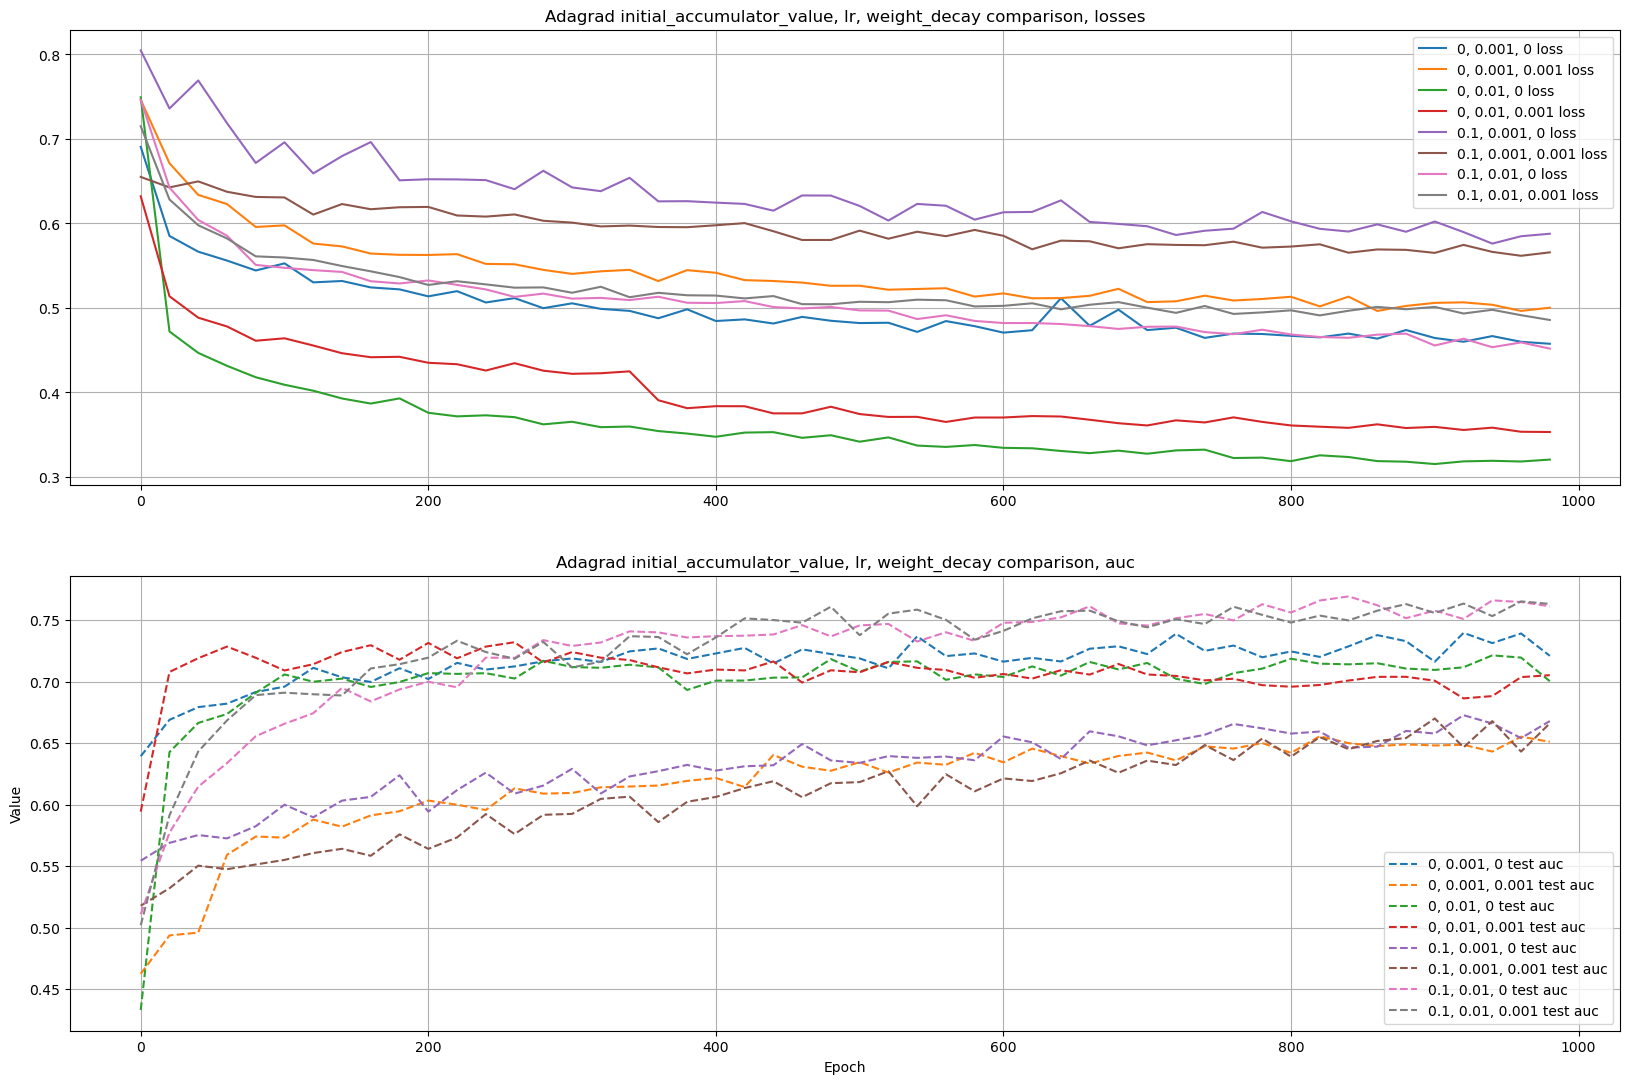

In [181]:
plot_loss_auc(
    epoch, 
    {'labels': list(map(lambda x: ', '.join(list(map(str, x.values()))), optimizer_params_grid)), 'losses': losses_, 'aucs': aucs_},
    title='Adagrad initial_accumulator_value, lr, weight_decay comparison')   

Как видно из графиков, значени параметра `initial_accumulator_value` сильно влияют на результаты обучения. Рассмотрим, как поведет себя модель при других значения этого параметра, больших, чем $0.1$. Зафиксируем значения других параметров на уровне `lr = 0.01` и `weight_decay = 0.01`

In [185]:
optimizer_params = {
    'lr': [0.01],
    'initial_accumulator_value': [0.1, 0.2, 0.5],
    'weight_decay': [1e-3]
}
optimizer_params_grid = list(ParameterGrid(optimizer_params))
losses_, aucs_ = [], []
epoch = 1000
verbose = 20
theta = 0.3
for optimizer_params in optimizer_params_grid:
    model = MODEL(
        geo_layer=SAGEConv, 
        in_feats_geo=train_g.ndata['feat'].shape[1], 
        h_feats_geo=16, 
        in_feats_act=train_g.ndata['activity'].shape[1], 
        h_feats_act=64, 
        num_geo_layers=2, 
        num_act_layers=3, 
        activation=F.silu
        )
    losses, aucs = [], []
    pred_act = EdgePred()
    pred_geo = DotPredictor()
    optimizer = torch.optim.Adagrad(model.parameters(), **optimizer_params)
    for e in tqdm(range(epoch)):
        # forward
        h1, h2 = model(train_g, train_g.ndata['feat'], train_g.ndata['activity'], train_g.edata['weight'], features='sep')        
        pos_score_act = pred_act(train_pos_g, h1)
        neg_score_act = pred_act(train_neg_g, h1)
        pos_score_geo = pred_geo(train_pos_g, h2)
        neg_score_geo = pred_geo(train_neg_g, h2)
        pos_score = theta * pos_score_act + (1 - theta) * pos_score_geo
        neg_score = theta * neg_score_act + (1 - theta) * neg_score_geo
        loss = compute_loss(pos_score, neg_score)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % verbose == 0:
            with torch.no_grad():
                pos_score_act = pred_act(test_pos_g, h1)
                neg_score_act = pred_act(test_neg_g, h1)
                pos_score_geo = pred_geo(test_pos_g, h2)
                neg_score_geo = pred_geo(test_neg_g, h2)
                pos_score = theta * pos_score_act + (1 - theta) * pos_score_geo
                neg_score = theta * neg_score_act + (1 - theta) * neg_score_geo
                roc_auc = compute_auc(pos_score, neg_score)
                losses.append(loss.item())
                aucs.append(roc_auc)
    losses_.append(losses)
    aucs_.append(aucs)

100%|██████████| 1000/1000 [07:01<00:00,  2.37it/s]


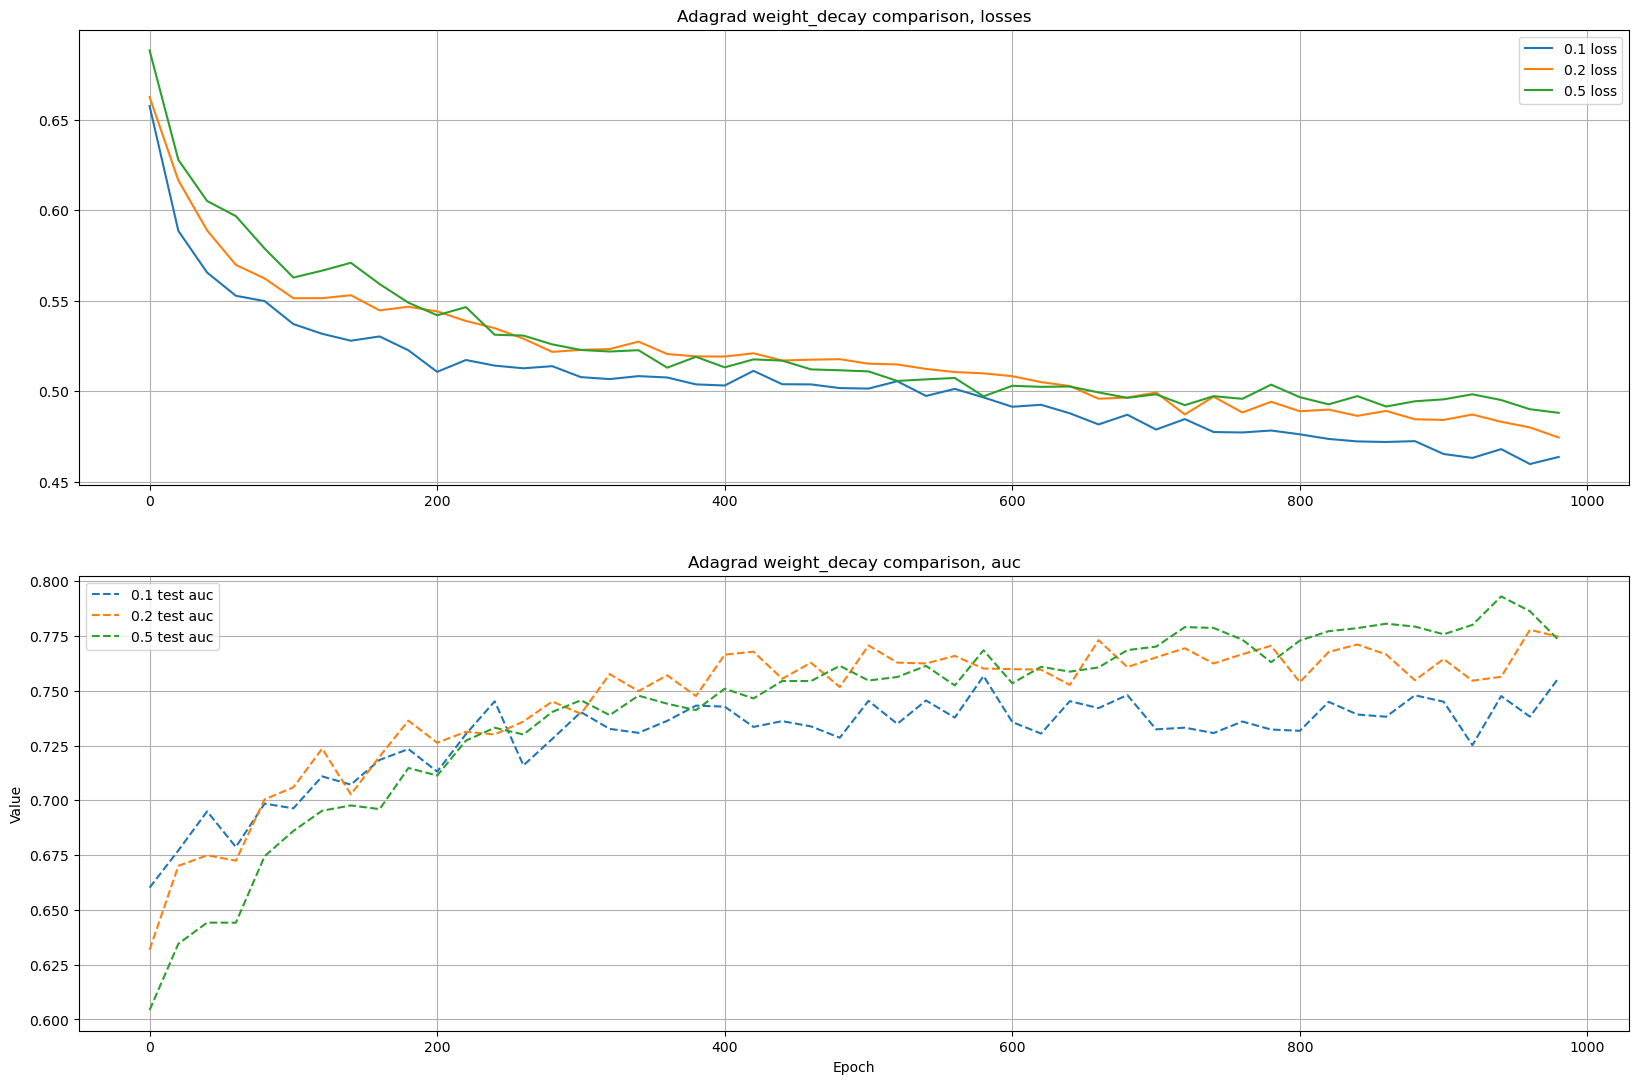

In [186]:
plot_loss_auc(
    epoch, 
    {'labels': ['0.1', '0.2', '0.5'], 'losses': losses_, 'aucs': aucs_},
    title='Adagrad weight_decay comparison')   

Видно, что при увеличении параметра `weight_decay` оптимизатора качество предсказаний модели возрастает. Так как значение метрики $\text{ROC AUC}$ по большей части не убывает, попробуем увеличить количество эпох обучения модели до с 1000 до 2000

In [187]:
optimizer_params = {
    'lr': 0.01,
    'initial_accumulator_value': 0.5,
    'weight_decay': 1e-3
}
epoch = 2000
verbose = 10
theta = 0.3
model = MODEL(
    geo_layer=SAGEConv, 
    in_feats_geo=train_g.ndata['feat'].shape[1], 
    h_feats_geo=16, 
    in_feats_act=train_g.ndata['activity'].shape[1], 
    h_feats_act=64, 
    num_geo_layers=2, 
    num_act_layers=3, 
    activation=F.silu
    )
losses, aucs = [], []
pred_act = EdgePred()
pred_geo = DotPredictor()
optimizer = torch.optim.Adagrad(model.parameters(), **optimizer_params)
for e in tqdm(range(epoch)):
    # forward
    h1, h2 = model(train_g, train_g.ndata['feat'], train_g.ndata['activity'], train_g.edata['weight'], features='sep')        
    pos_score_act = pred_act(train_pos_g, h1)
    neg_score_act = pred_act(train_neg_g, h1)
    pos_score_geo = pred_geo(train_pos_g, h2)
    neg_score_geo = pred_geo(train_neg_g, h2)
    pos_score = theta * pos_score_act + (1 - theta) * pos_score_geo
    neg_score = theta * neg_score_act + (1 - theta) * neg_score_geo
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % verbose == 0:
        with torch.no_grad():
            pos_score_act = pred_act(test_pos_g, h1)
            neg_score_act = pred_act(test_neg_g, h1)
            pos_score_geo = pred_geo(test_pos_g, h2)
            neg_score_geo = pred_geo(test_neg_g, h2)
            pos_score = theta * pos_score_act + (1 - theta) * pos_score_geo
            neg_score = theta * neg_score_act + (1 - theta) * neg_score_geo
            roc_auc = compute_auc(pos_score, neg_score)
            losses.append(loss.item())
            aucs.append(roc_auc)

100%|██████████| 2000/2000 [14:11<00:00,  2.35it/s]


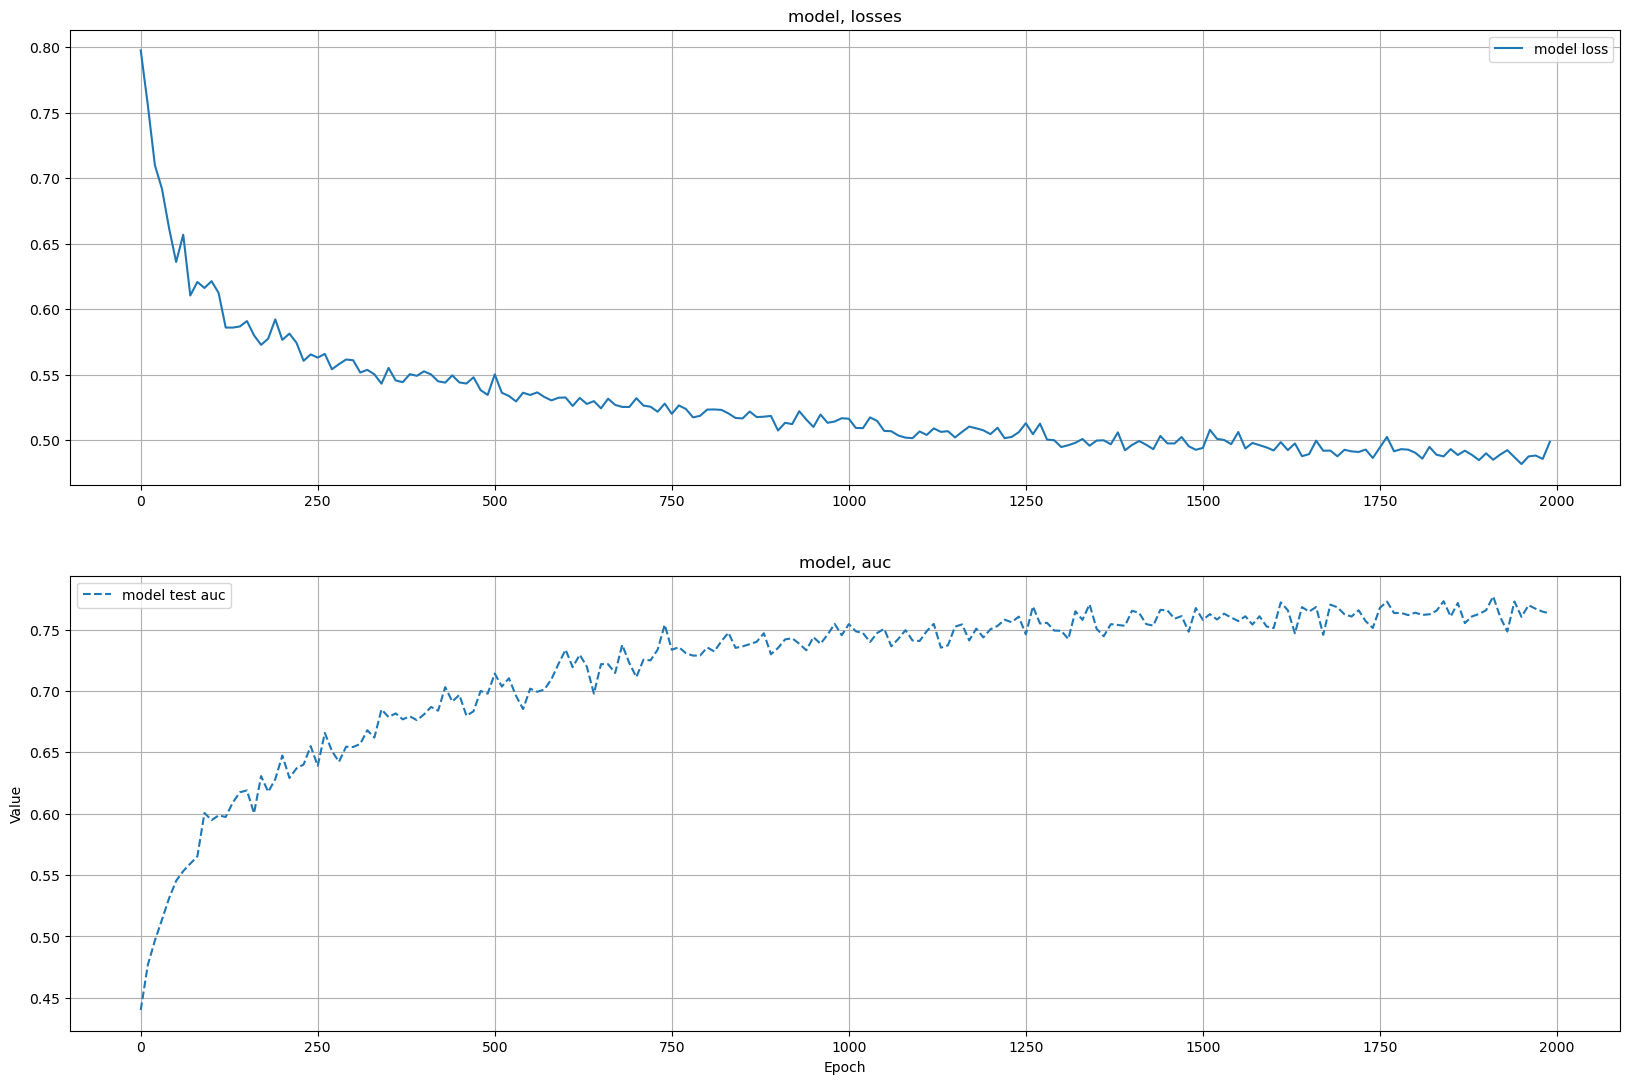

In [188]:
plot_loss_auc(
    epoch, 
    {'labels': ['model'], 'losses': [losses], 'aucs': [aucs]},
    title='model')   

### Подбор параметров Dropout

**Dropout** — это метод регуляризации для предотвращения переобучения. Во время обучения каждый узел (нейрон) в слое с вероятностью $p$ удаляется (обнуляется) из сети, что означает, что его выход не передается к следующему слою. 

Формально, для значения активации нейрона $x$ во время обучения, dropout определяется следующим образом:

$ \text{dropout}(x) = \begin{cases} 
0, & \text{с вероятностью } p \\ 
\frac{x}{1 - p}, & \text{с вероятностью } 1 - p 
\end{cases} $

где $p$ — вероятность dropout.


In [193]:
dropouts = [0.1, 0.2, 0.4]
dropouts_combs = get_combs(dropouts, 2)
losses_, aucs_ = [], []
for dropouts_comb in dropouts_combs:
    epoch = 2000
    verbose = 10
    theta = 0.3
    model = MODEL(
        geo_layer=SAGEConv, 
        in_feats_geo=train_g.ndata['feat'].shape[1], 
        h_feats_geo=16, 
        in_feats_act=train_g.ndata['activity'].shape[1], 
        h_feats_act=64, 
        num_geo_layers=2, 
        num_act_layers=3, 
        activation=F.silu, 
        *dropouts_comb
        )
    losses, aucs = [], []
    pred_act = EdgePred()
    pred_geo = DotPredictor()
    optimizer = torch.optim.Adagrad(model.parameters(), **optimizer_params)
    for e in tqdm(range(epoch)):
        # forward
        h1, h2 = model(train_g, train_g.ndata['feat'], train_g.ndata['activity'], train_g.edata['weight'], features='sep')        
        pos_score_act = pred_act(train_pos_g, h1)
        neg_score_act = pred_act(train_neg_g, h1)
        pos_score_geo = pred_geo(train_pos_g, h2)
        neg_score_geo = pred_geo(train_neg_g, h2)
        pos_score = theta * pos_score_act + (1 - theta) * pos_score_geo
        neg_score = theta * neg_score_act + (1 - theta) * neg_score_geo
        loss = compute_loss(pos_score, neg_score)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % verbose == 0:
            with torch.no_grad():
                pos_score_act = pred_act(test_pos_g, h1)
                neg_score_act = pred_act(test_neg_g, h1)
                pos_score_geo = pred_geo(test_pos_g, h2)
                neg_score_geo = pred_geo(test_neg_g, h2)
                pos_score = theta * pos_score_act + (1 - theta) * pos_score_geo
                neg_score = theta * neg_score_act + (1 - theta) * neg_score_geo
                roc_auc = compute_auc(pos_score, neg_score)
                losses.append(loss.item())
                aucs.append(roc_auc)
    losses_.append(losses)
    aucs_.append(aucs)

100%|██████████| 2000/2000 [12:11<00:00,  2.73it/s]


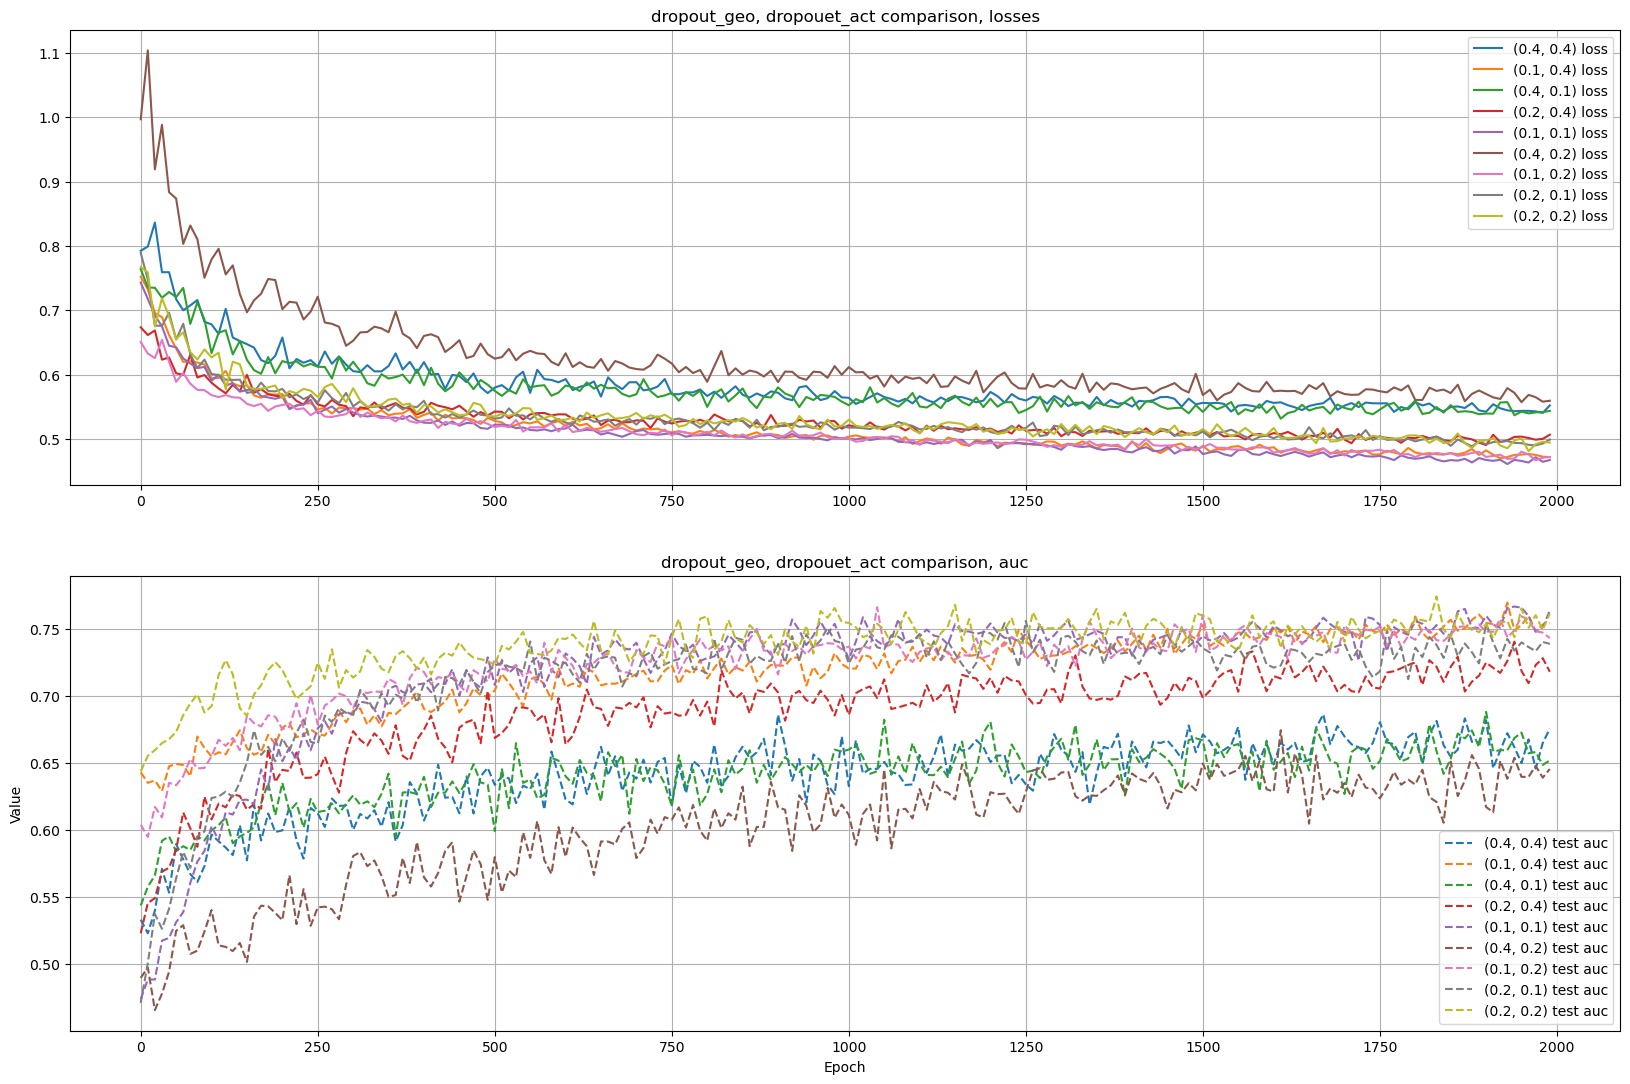

In [197]:
plot_loss_auc(
    epoch, 
    {'labels': list(map(str, dropouts_combs)), 'losses': losses_, 'aucs': aucs_},
    title='dropout_geo, dropouet_act comparison')   

Видим, что оптимальное значение Dropout для каждого типа признака стоит на уровне 0.2

### Финальное обучение и сохранение модели

In [332]:
class DotPredictor(torch.nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return g.edata['score'][:, 0]

class EdgePred(torch.nn.Module):
    def forward(self, g, h, op='cos'):
        src, dst = g.edges()
        h_src = h[src]
        h_dst = h[dst]
        return dgl.nn.EdgePredictor(op=op)(h_src, h_dst)[:, 0]

In [333]:
epoch = 10000
verbose = 20
theta = 0.3
model = MODEL(
    geo_layer=SAGEConv, 
    in_feats_geo=train_g.ndata['feat'].shape[1], 
    h_feats_geo=16, 
    in_feats_act=train_g.ndata['activity'].shape[1], 
    h_feats_act=64, 
    num_geo_layers=2, 
    num_act_layers=3, 
    activation=F.silu, 
    dropout_geo=0.2,
    dropout_act=0.2
    )
losses, aucs = [], []
pred_act = EdgePred()
pred_geo = DotPredictor()
optimizer_params = {'lr': 0.01, 'initial_accumulator_value': 0.5, 'weight_decay': 0.001}
optimizer = torch.optim.Adagrad(model.parameters(), **optimizer_params)
for e in tqdm(range(epoch)):
    # forward
    h1, h2 = model(train_g, train_g.ndata['feat'], train_g.ndata['activity'], train_g.edata['weight'], features='sep')        
    pos_score_act = pred_act(train_pos_g, h1)
    neg_score_act = pred_act(train_neg_g, h1)
    pos_score_geo = pred_geo(train_pos_g, h2)
    neg_score_geo = pred_geo(train_neg_g, h2)
    pos_score = theta * pos_score_act + (1 - theta) * pos_score_geo
    neg_score = theta * neg_score_act + (1 - theta) * neg_score_geo
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % verbose == 0:
        with torch.no_grad():
            pos_score_act = pred_act(test_pos_g, h1)
            neg_score_act = pred_act(test_neg_g, h1)
            pos_score_geo = pred_geo(test_pos_g, h2)
            neg_score_geo = pred_geo(test_neg_g, h2)
            pos_score = theta * pos_score_act + (1 - theta) * pos_score_geo
            neg_score = theta * neg_score_act + (1 - theta) * neg_score_geo
            roc_auc = compute_auc(pos_score, neg_score)
            losses.append(loss.item())
            aucs.append(roc_auc)

100%|██████████| 10000/10000 [1:00:27<00:00,  2.76it/s]


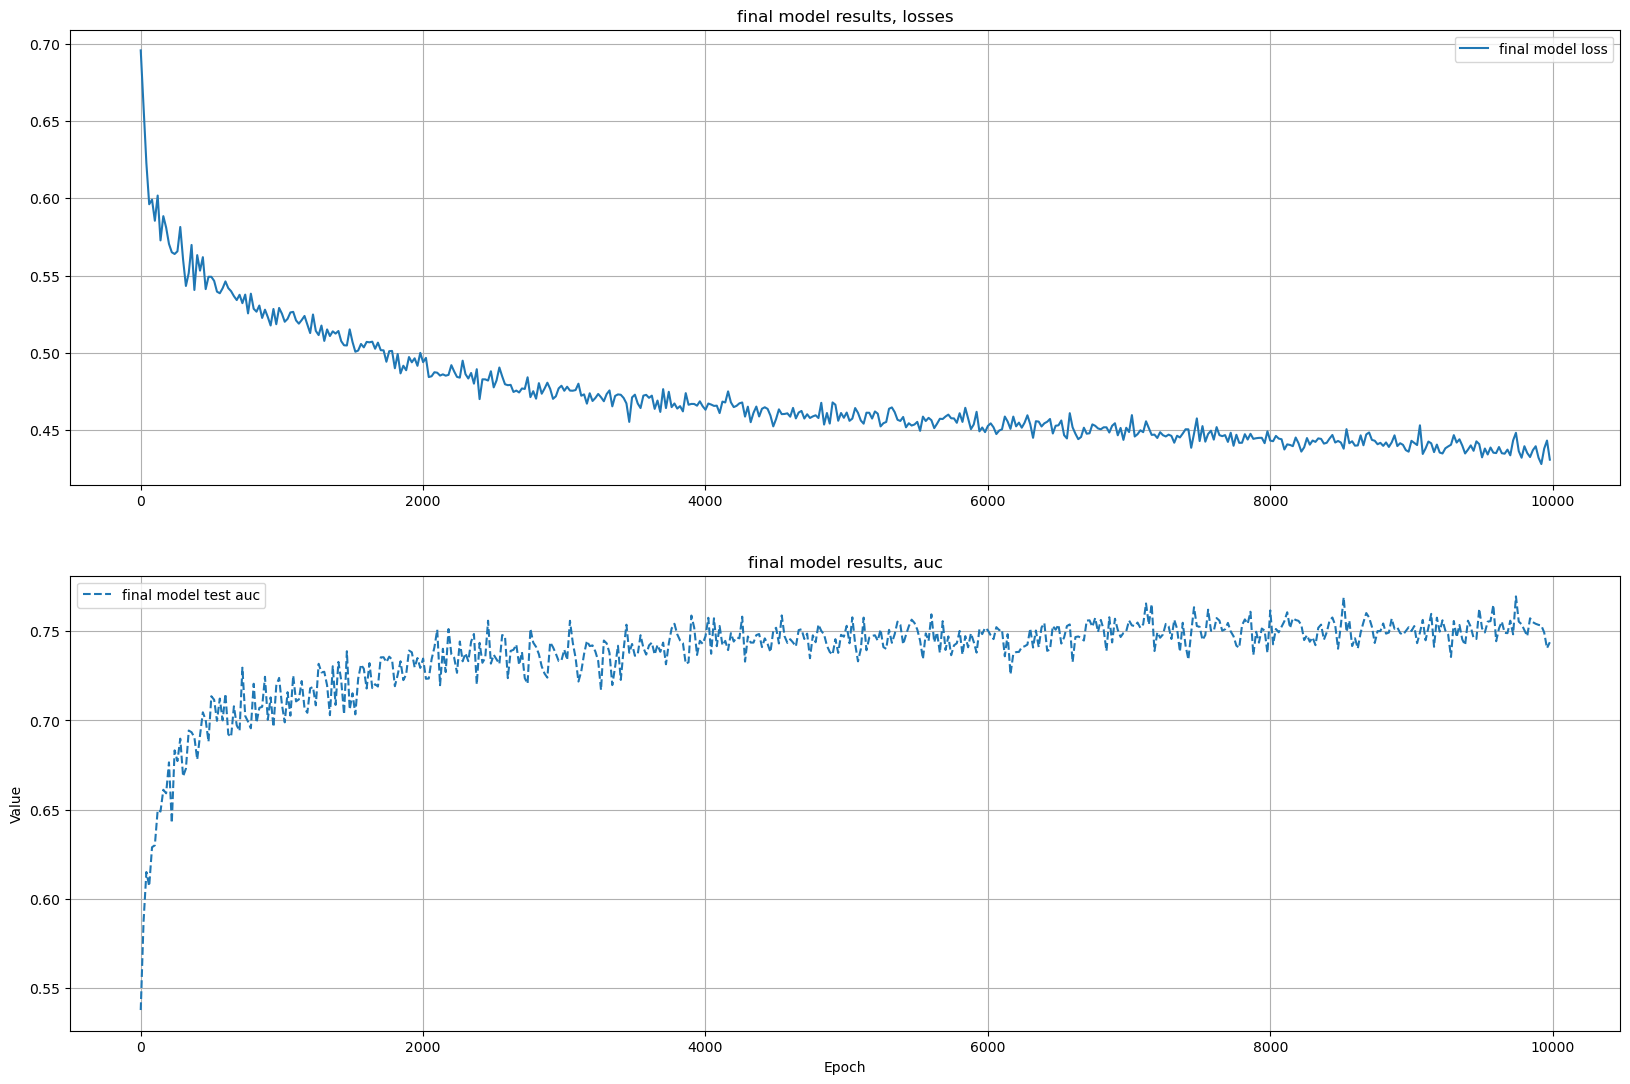

In [334]:
plot_loss_auc(
    epoch, 
    {'labels': ['final model'], 'losses': [losses], 'aucs': [aucs]},
    title='final model results')   

In [341]:
torch.save(model, 'model.pth')

## Оценка качества работы модели

ROC AUC на тесте: 0.7836729238063335


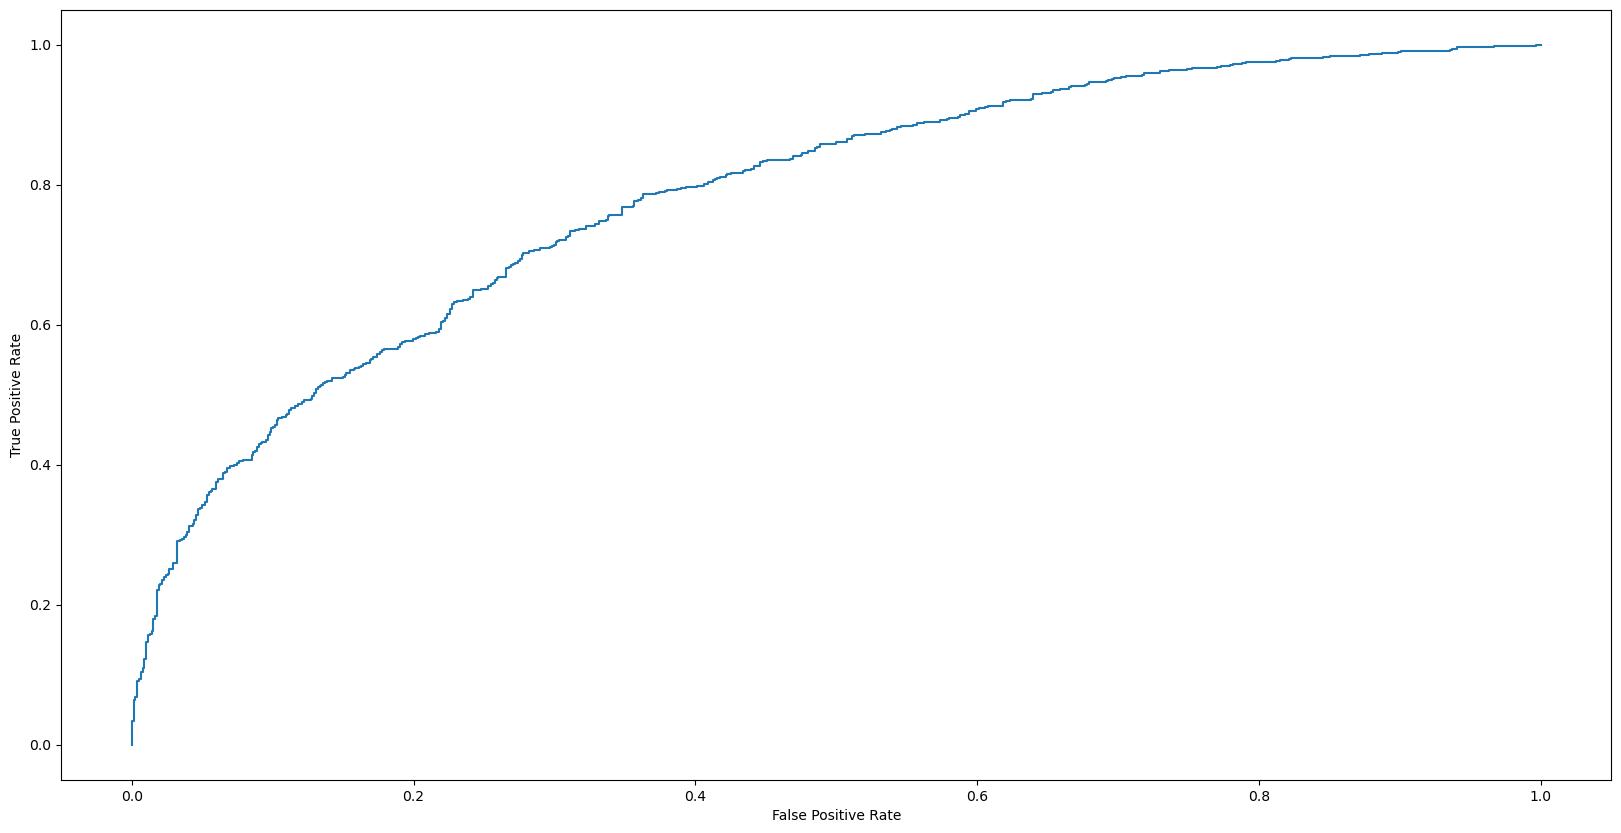

In [7]:
model = torch.load('model.pth')
train_g, test_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g = dgl.load_graphs('graphs.bin')[0]
model.eval()
theta = 0.3
pred_act = EdgePred()
pred_geo = DotPredictor()
with torch.no_grad():
        h1, h2 = model(train_g, train_g.ndata['feat'], train_g.ndata['activity'], train_g.edata['weight'], features='sep')        
        pos_score_act = pred_act(test_pos_g, h1)
        neg_score_act = pred_act(test_neg_g, h1)
        pos_score_geo = pred_geo(test_pos_g, h2)
        neg_score_geo = pred_geo(test_neg_g, h2)
        pos_score = theta * pos_score_act + (1 - theta) * pos_score_geo
        neg_score = theta * neg_score_act + (1 - theta) * neg_score_geo
        roc_auc = compute_auc(pos_score, neg_score) 
        print(f'ROC AUC на тесте: {roc_auc}')   

        scores = torch.cat([pos_score, neg_score]).detach().numpy()
        labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
        fpr, tpr, _ = roc_curve(labels, scores)

        plt.figure(figsize=FIGSIZE)
        plt.plot (fpr,tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

## Создание рекомендательной системы на основе модели

Данная **рекомендательная система** принимает несколько параметров:

* **tin** - ИНН компании, для которо1 мы хотим получить рекомендации

* **price** - стоимость контракта

* **supplier** - это флаг, указывающий, на то, является ли наша компания исполнителем или заказчиком

* **contract** - описание контракта

* **topk** - это параметр, определяющий количество рекомендаций, которые система должна предоставить. В стандандартном случае, система будет возвращать топ-5 рекомендаций

**Рекомендательная система работает следующим образом**:
1. Создаем признаки, соответствующие нашей вершине (местоположение, вид деятельности, суть контракта)
2. Затем мы создаем вершину графа, который представляет нашу компанию.
3. Далее мы получаем список всех вершин графа, которые были представлены в качестве поставщиков или покупателей в нашем графе.
4. В зависимости от значение параметра `supplier` мы соединяем вершину пользователя с вершинами поставщиков или покупателей. 
5. Затем мы получаем список всех ребер с указанными вероятностями возникновения этих ребер.
6. Далее мы сортируем список ребер по убыванию вероятности их возникновения.
7. Затем мы проходим по списку ребер и получаем вершины, которые соединяются с вершиной пользователя. Если вершина еще не была добавлена в список рекомендаций, то мы добавляем ее в список рекомендаций. Если список рекомендаций достиг максимального размера, то мы прекращаем проход по списку ребер.
8. В конце мы возвращаем список рекомендаций в формате *(ИНН, название, юр. адрес)*.

In [19]:
%%writefile recommend_system.py
from copy import deepcopy
from sentence_transformers import SentenceTransformer
from dadata import Dadata
from const import DADATA_TOKEN, DADATA_SECRET
from modeling import preproc_strigs, EdgePred, DotPredictor
import pandas as pd
import dgl
import numpy as np
import torch
from MODEL import MODEL
sent_transf_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
okved = pd.read_csv('okved.csv', index_col='Код')
tins = pd.read_csv('tin_legal.csv', index_col=0)
dadata = Dadata(DADATA_TOKEN, DADATA_SECRET)
g = dgl.load_graphs('graph2.bin')[0][0]
mean = np.load('mean.npy')
sigma = np.load('sigma.npy')
model = torch.load('model.pth')
def recommend_system(tin, price, supplier=True, contract='', topk=5):

    company_info = dadata.find_by_id(name='party', query=str(tin))[0]['data']
    city_lat = company_info['address']['data']['geo_lat']
    city_lng = company_info['address']['data']['geo_lon']
    okved_code = company_info['okved']
    
    geo_feat = np.array([city_lat, 
                          city_lng, 
                          price, 
                          price, 
                          price,
                          price,
                          1 if supplier else 0, 
                          0 if supplier else 1]).astype(np.float32)
    
    act_feat = sent_transf_model.encode([preproc_strigs(okved.loc[okved_code].values[0])])[0]
    contact_feat = sent_transf_model.encode([preproc_strigs(contract)])[0]
    geo_feat = (geo_feat - mean) / sigma
    geo_feat = geo_feat.astype(np.float32)
    geo_feat = torch.from_numpy(geo_feat)
    geo_feat = geo_feat.unsqueeze(0)
    geo, act, weight = g.ndata['feat'], g.ndata['activity'], g.edata['weight']
    g_ = deepcopy(g)
    g_.add_nodes(1)
    g_.ndata['feat'] = torch.cat([geo, torch.Tensor(geo_feat).reshape(1, -1)])
    g_.ndata['activity'] = torch.cat([act, torch.Tensor(act_feat).reshape(1, -1)])   

    new_edges = []

    if supplier:
        for i in range(g_.number_of_nodes() - 1):
            new_edges.append((i, g_.number_of_nodes() - 1))
    else:
        for i in range(g_.number_of_nodes() - 1):
            new_edges.append((g_.number_of_nodes() - 1, i))
        
    new_edges = np.array(new_edges)
    g_.add_edges(new_edges[:, 0], new_edges[:, 1])
    g_.edata['weight'] = torch.cat([weight, torch.Tensor(contact_feat).repeat(new_edges.shape[0], 1)])

    theta = 0.9
    pred_act = EdgePred()
    pred_geo = DotPredictor()
    with torch.no_grad():
        h1, h2 = model(g_, g_.ndata['feat'], g_.ndata['activity'], g_.edata['weight'], features='sep')        
        pos_score_act = pred_act(g_, h1)
        pos_score_geo = pred_geo(g_, h2)
        pos_score = theta * pos_score_act + (1 - theta) * pos_score_geo
        pos_score = pos_score.detach().numpy()

    topk = np.argsort(pos_score)[-topk:]
    topk = topk[::-1]
    edges = g_.edges()
    if supplier:
        res_tins = tins.loc[np.array(edges[0])[[*topk]]]['ИНН'].values
    else:
        res_tins = tins.loc[np.array(edges[1])[[*topk]]]['ИНН'].values
    
    for tin in res_tins:
        data_tin = dadata.find_by_id(name="party", query=str(tin))[0]["data"]
        print(f'ИНН: {tin}, название: {data_tin["name"]["short_with_opf"]}, юр. адрес: {data_tin["address"]["value"]}')

Overwriting recommend_system.py


Пример работы

In [28]:
from recommend_system import recommend_system
recommend_system(7840069184, 100000, contract='образование детей и взрослых', supplier=True, topk=5)

ИНН: 7715995942, название: АО "ИЗДАТЕЛЬСТВО "ПРОСВЕЩЕНИЕ", юр. адрес: г Москва, ул Краснопролетарская, д 16 стр 3, помещ 1Н
ИНН: 7724922443, название: ООО "АЛЬБАТРОС", юр. адрес: г Москва, Каширское шоссе, д 22 к 4 стр 7, помещ 5
ИНН: 7731241639, название: АО "ФИРМА ЕВРОСЕРВИС", юр. адрес: 142717, Московская область, Г.О. ЛЕНИНСКИЙ, П РАЗВИЛКА, ТЕР КВАРТАЛ 1, ВЛД. 7, ПОМЕЩ. КАБИНЕТ 160
ИНН: 7726311464, название: АО "Р-ФАРМ", юр. адрес: г Москва, ул Берзарина, д 19 к 1
ИНН: 7717035419, название: ФГБОУ ВО "АКАДЕМИЯ ГПС МЧС РОССИИ" АКАДЕМИЯ ГПС МЧС РОССИИ АКАДЕМИЯ ГОСУДАРСТВЕННОЙ ПРОТИВОПОЖАРНОЙ СЛУЖБЫ МИНИСТЕРСТВА РОССИЙСКОЙ ФЕДЕРАЦИИ ПО ДЕЛАМ ГРАЖДАНСКОЙ ОБОРОНЫ, ЧРЕЗВЫЧАЙНЫМ СИТУАЦИЯМ И ЛИКВИДАЦИИ ПОСЛЕДСТВИЙ СТ..., юр. адрес: г Москва, ул Бориса Галушкина, д 4


## Выводы

Данная курсовая работа была посвящена применению алгоритмов машинного обучения для задачи предсказания связей для построения рекомендательной системы.
Был осуществлен сбор нужных данных из различных источников, предобработка данных для построения графа на их основе. Была создана и настроена модель графовой нейронной сети.  

Для оценки качества моделей использовалась метрика ROC AUC, которая позволяет оценить качество предсказания моделью наличия/отсутствия связи, учитывая истинно-положительные и ложно-положительные результаты. Значение метрики финальной модели, используемой в рекомендательной системе:
$$\text{ROC AUC: 0.7836729238063335}$$